### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

### Loading the data

In [4]:
official_names = ['Pinene', 'Benzyl_benzoate']

In [5]:
os.getcwd()

'/home/basia/Documents/spectroscopy/magnetstein_data/experiment_1_intensity_difference'

In [6]:
mix = np.loadtxt(os.getcwd()+'/benzyl_benzoate_pinene_duza_roznica_intensywnosci_pikow.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 1, 2],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [7]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [8]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [9]:
mix = Spectrum(confs=list(zip(ppm,mix)))

In [10]:
# mix.plot(profile=True)
# spectra[0].plot(profile=True)
# spectra[1].plot(profile=True)

### Ground truth

In [11]:
protons = [16, 12]
mass_proportions = [0.0603, 0.9397]
molar_masses = [136.24, 212.25]

In [12]:
molar_proportions = [mass_prop/mol_mass for mass_prop, mol_mass in zip(mass_proportions, molar_masses)]
molar_proportions = [mol_prop/sum(molar_proportions) for mol_prop in molar_proportions]

In [13]:
molar_proportions

[0.09088457406472417, 0.9091154259352758]

In [14]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [15]:
real_visible_proportions

[0.11761626406540927, 0.8823837359345907]

In [16]:
mass_proportions

[0.0603, 0.9397]

### Preprocessing

In [17]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [18]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [19]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [20]:
spectra_and_mixture = spectra + [mix]

In [21]:
spectra_and_mixture = shift(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [23]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [24]:
cma = common_mass_axis(spectra_and_mixture)

In [25]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [26]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [27]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [28]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [29]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


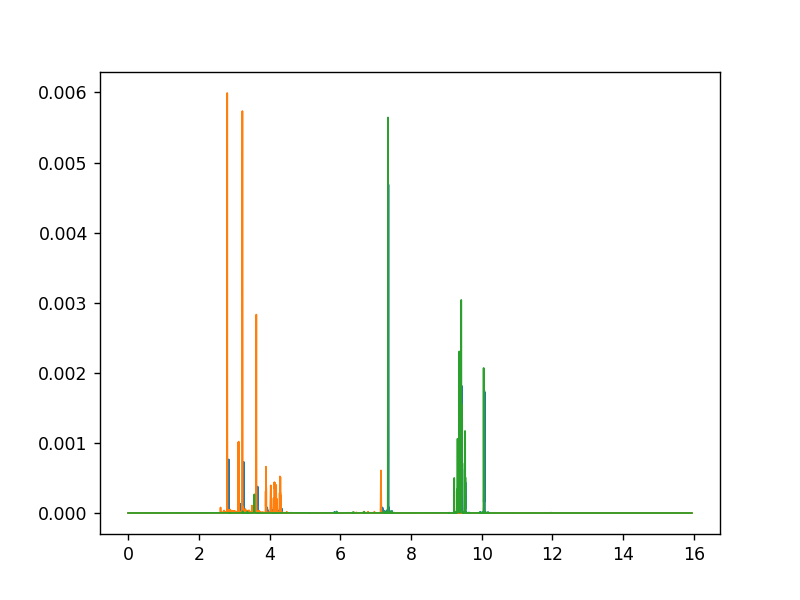

In [30]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Finding best values of the parameters

In [31]:
import time
import pandas as pd
import pulp

In [32]:
lower_limit = 0.01
upper_limit = 0.3
step = 0.01

In [34]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3446269.57it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.12s/it]


Estimation for 0.01 and 0.01 done
It took: 189.27106976509094 seconds.
[0.004978539199000028, 0.6327822619960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3591320.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.32s/it]


Estimation for 0.01 and 0.02 done
It took: 192.46171641349792 seconds.
[0.002270173790000013, 0.547106646037003]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3516726.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:29<00:00, 869.52s/it]


Estimation for 0.01 and 0.03 done
It took: 869.6638581752777 seconds.
[0.0021703224320000123, 0.47530895180000265]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3407225.37it/s]
Deconvolving chunks: 100%|███████████████████| 1/1 [3:39:28<00:00, 13168.45s/it]


Estimation for 0.01 and 0.04 done
It took: 13168.592165708542 seconds.
[0.0021228843240000115, 0.46496188578400255]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451483.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.06s/it]


Estimation for 0.01 and 0.05 done
It took: 168.21915483474731 seconds.
[0.0019673489720000107, 0.4544039270820025]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487501.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:03<00:00, 903.89s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 904.0341403484344 seconds.
[0.00181231766500001, 0.44408892340900247]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3547773.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:06<00:00, 846.29s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 846.4292216300964 seconds.
[0.0014875013440000082, 0.4318170187400024]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3640694.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:02<00:00, 842.43s/it]


Estimation for 0.01 and 0.08 done
It took: 842.5687580108643 seconds.
[0.0009856983310000055, 0.4242723334580023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3617457.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:20<00:00, 860.53s/it]


Estimation for 0.01 and 0.09 done
It took: 860.6697914600372 seconds.
[0.0006496267530000035, 0.4215525191900023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531274.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:51<00:00, 951.37s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 951.5193448066711 seconds.
[0.0005881793490000032, 0.41999213220300236]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437090.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:25<00:00, 325.99s/it]


Estimation for 0.01 and 0.11 done
It took: 326.1400601863861 seconds.
[0.0005780989430000033, 0.4199014387270023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3394602.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:35<00:00, 335.71s/it]


Estimation for 0.01 and 0.12 done
It took: 335.85532569885254 seconds.
[0.0005782255670000033, 0.41820298330700234]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3147324.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:00<00:00, 360.91s/it]


Estimation for 0.01 and 0.13 done
It took: 361.07029151916504 seconds.
[0.0005783289850000032, 0.41683198200900234]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435952.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:05<00:00, 365.77s/it]


Estimation for 0.01 and 0.14 done
It took: 365.91277027130127 seconds.
[0.0005783316210000032, 0.41683388186300235]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412343.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:21<00:00, 381.89s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 382.03670597076416 seconds.
[0.0005726312710000031, 0.4152166243030023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3137660.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:25<00:00, 385.51s/it]


Estimation for 0.01 and 0.16 done
It took: 385.6786296367645 seconds.
[0.0005718110610000031, 0.4146457677050023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3456974.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:32<00:00, 392.22s/it]


Estimation for 0.01 and 0.17 done
It took: 392.374228477478 seconds.
[0.0005727668940000031, 0.41366067025400227]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450617.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:55<00:00, 415.65s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 415.80996656417847 seconds.
[0.0005727549130000032, 0.41351141828000226]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3162697.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:06<00:00, 426.93s/it]


Estimation for 0.01 and 0.19 done
It took: 427.09934735298157 seconds.
[0.0005713190080000031, 0.41275528759900226]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3114781.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:03<00:00, 423.92s/it]


Estimation for 0.01 and 0.2 done
It took: 424.08743357658386 seconds.
[0.0005713804170000031, 0.4113796814810023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3256287.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:01<00:00, 421.68s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 421.8381118774414 seconds.
[0.0005671389940000031, 0.4102502067380023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494462.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:02<00:00, 422.92s/it]


Estimation for 0.01 and 0.22 done
It took: 423.0662624835968 seconds.
[0.0005669321740000031, 0.40995754294200226]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3436768.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:20<00:00, 440.65s/it]


Estimation for 0.01 and 0.23 done
It took: 440.79376339912415 seconds.
[0.0005670196160000032, 0.4085125650090023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3318759.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:35<00:00, 455.45s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 455.60539507865906 seconds.
[0.0005670898690000031, 0.4073537113330023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3189930.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:37<00:00, 457.99s/it]


Estimation for 0.01 and 0.25 done
It took: 458.14528465270996 seconds.
[0.0005635093200000032, 0.4070439123140023]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398526.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:26<00:00, 507.00s/it]


Estimation for 0.01 and 0.26 done
It took: 507.1431212425232 seconds.
[0.0005619052090000032, 0.40633325311400226]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2974144.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:26<00:00, 506.53s/it]


Estimation for 0.01 and 0.27 done
It took: 506.6854341030121 seconds.
[0.0005561264220000031, 0.40610571927800226]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3497241.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:21<00:00, 501.13s/it]


Estimation for 0.01 and 0.28 done
It took: 501.2763683795929 seconds.
[0.000556154631000003, 0.4056419394190023]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 6574.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3085326.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:02<00:00, 542.63s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 542.8039553165436 seconds.
[0.000556207927000003, 0.4047506605140022]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3118544.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.83s/it]


Estimation for 0.02 and 0.01 done
It took: 163.01865458488464 seconds.
[0.09294500923200051, 0.8410241054210047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3048237.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.33s/it]


Estimation for 0.02 and 0.02 done
It took: 189.51624631881714 seconds.
[0.005313500971000029, 0.7900773021440044]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11865.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3096308.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.01s/it]


Estimation for 0.02 and 0.03 done
It took: 197.17271876335144 seconds.
[0.004946544730000028, 0.7868597462260043]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2816429.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.25s/it]


Estimation for 0.02 and 0.04 done
It took: 209.42135405540466 seconds.
[0.004826824271000027, 0.7616303245500042]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29537.35it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 1475375.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:05<00:00, 785.47s/it]


Estimation for 0.02 and 0.05 done
It took: 785.6953167915344 seconds.
[0.004691813699000026, 0.7547275017670042]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445923.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.34s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 191.48467445373535 seconds.
[0.004610336600000026, 0.7519109981590042]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3515647.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.27s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 178.43466114997864 seconds.
[0.004334218763000024, 0.7487204298720042]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3551050.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.77s/it]


Estimation for 0.02 and 0.08 done
It took: 192.93453168869019 seconds.
[0.0039009476530000218, 0.7482102628530041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411940.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.89s/it]


Estimation for 0.02 and 0.09 done
It took: 208.0633945465088 seconds.
[0.003416686100000019, 0.7513695186910042]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3462221.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.85s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 185.9905025959015 seconds.
[0.0032686920950000184, 0.7505240966490042]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3377417.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.28s/it]


Estimation for 0.02 and 0.11 done
It took: 190.4245023727417 seconds.
[0.003201219947000018, 0.7498109095640041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426273.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.79s/it]


Estimation for 0.02 and 0.12 done
It took: 183.9326355457306 seconds.
[0.0031981361120000176, 0.7452626922070041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3428944.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.54s/it]


Estimation for 0.02 and 0.13 done
It took: 183.68828582763672 seconds.
[0.0032043951460000177, 0.741227455147004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494484.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.65s/it]


Estimation for 0.02 and 0.14 done
It took: 184.79122638702393 seconds.
[0.003203468110000018, 0.7412315749360041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3554631.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.28s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 185.41693377494812 seconds.
[0.0032035279760000176, 0.7408829761260041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3427405.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.41s/it]


Estimation for 0.02 and 0.16 done
It took: 188.54859137535095 seconds.
[0.003202855115000018, 0.7405535161400041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507236.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.47s/it]


Estimation for 0.02 and 0.17 done
It took: 188.61049032211304 seconds.
[0.0032025460510000177, 0.740448770950004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3422902.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.76s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 189.92091393470764 seconds.
[0.0032002596920000176, 0.7404522881750041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430463.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.28s/it]


Estimation for 0.02 and 0.19 done
It took: 190.4193525314331 seconds.
[0.003201178687000018, 0.7402479746730041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469760.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.44s/it]


Estimation for 0.02 and 0.2 done
It took: 186.60567808151245 seconds.
[0.003199433887000018, 0.7399522575680041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3548185.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.22s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 182.35628151893616 seconds.
[0.0031962373820000178, 0.7396665642250041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3489361.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.84s/it]


Estimation for 0.02 and 0.22 done
It took: 188.98342490196228 seconds.
[0.0031948106030000177, 0.7396711239040041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3340965.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.44s/it]


Estimation for 0.02 and 0.23 done
It took: 192.5803198814392 seconds.
[0.003193199156000018, 0.7396647668080041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487855.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.26s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 180.42600631713867 seconds.
[0.0031895908590000178, 0.7393952567110041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415077.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.14s/it]


Estimation for 0.02 and 0.25 done
It took: 180.29371809959412 seconds.
[0.0031896650340000176, 0.7391120200960041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3337051.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.74s/it]


Estimation for 0.02 and 0.26 done
It took: 190.88173532485962 seconds.
[0.003184109558000018, 0.739114630750004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487767.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.17s/it]


Estimation for 0.02 and 0.27 done
It took: 238.3123483657837 seconds.
[0.0031784466200000176, 0.7389465751040041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3399808.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.78s/it]


Estimation for 0.02 and 0.28 done
It took: 259.9431357383728 seconds.
[0.0031725082940000176, 0.738834633884004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505514.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.42s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 255.5847225189209 seconds.
[0.003172527523000018, 0.7388391121990041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3413763.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:43<00:00, 283.34s/it]


Estimation for 0.03 and 0.01 done
It took: 283.4833676815033 seconds.
[0.2542578795810014, 0.728765153290004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443635.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.37s/it]


Estimation for 0.03 and 0.02 done
It took: 164.51666378974915 seconds.
[0.04281990290200024, 0.8628598851720047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411686.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.71s/it]


Estimation for 0.03 and 0.03 done
It took: 158.8539822101593 seconds.
[0.027465596009000153, 0.8514950964640048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454390.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.34s/it]


Estimation for 0.03 and 0.04 done
It took: 172.48095512390137 seconds.
[0.026028699438000145, 0.8487932420280047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491865.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.23s/it]


Estimation for 0.03 and 0.05 done
It took: 162.3999924659729 seconds.
[0.024370192446000135, 0.8427777606180047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451722.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.03s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 174.19394636154175 seconds.
[0.02333145487000013, 0.8272491733460046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3460173.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.47s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 171.64259791374207 seconds.
[0.02181842625400012, 0.8234694717720046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455497.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.99s/it]


Estimation for 0.03 and 0.08 done
It took: 169.12795996665955 seconds.
[0.017688283838000095, 0.8275901273290045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451505.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.42s/it]


Estimation for 0.03 and 0.09 done
It took: 175.55938291549683 seconds.
[0.01609001908500009, 0.8288886742210045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3432112.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.99s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 171.1322159767151 seconds.
[0.015468631653000085, 0.8285980167420045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3544639.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.46s/it]


Estimation for 0.03 and 0.11 done
It took: 169.62795400619507 seconds.
[0.014867795251000083, 0.8281852941260045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470527.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 171.00s/it]


Estimation for 0.03 and 0.12 done
It took: 171.13739013671875 seconds.
[0.014537203627000082, 0.8259927208200045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451613.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.21s/it]


Estimation for 0.03 and 0.13 done
It took: 174.35806131362915 seconds.
[0.014126198792000078, 0.8252591214570045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396321.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.70s/it]


Estimation for 0.03 and 0.14 done
It took: 180.84668588638306 seconds.
[0.013705846819000077, 0.8233946664900046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430035.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.58s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 171.7251079082489 seconds.
[0.013779319919000076, 0.8149430463400046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3436295.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.09s/it]


Estimation for 0.03 and 0.16 done
It took: 179.25417518615723 seconds.
[0.013676168280000076, 0.8149510007460046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405452.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.37s/it]


Estimation for 0.03 and 0.17 done
It took: 182.51451969146729 seconds.
[0.013518475263000075, 0.8149567588700045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451288.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.28s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 175.42536783218384 seconds.
[0.013426621548000074, 0.8146848348630046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465102.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.33s/it]


Estimation for 0.03 and 0.19 done
It took: 172.49153447151184 seconds.
[0.013349560240000075, 0.8146895930520045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448431.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.68s/it]


Estimation for 0.03 and 0.2 done
It took: 176.82209014892578 seconds.
[0.013240834743000073, 0.8146971802080045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471820.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.82s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 172.98704385757446 seconds.
[0.013156265176000072, 0.8145504234980045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447177.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.09s/it]


Estimation for 0.03 and 0.22 done
It took: 180.253657579422 seconds.
[0.013106073058000073, 0.8144428868780046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423840.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.77s/it]


Estimation for 0.03 and 0.23 done
It took: 182.9102280139923 seconds.
[0.012953469508000071, 0.8144259730400045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3367838.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.99s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 182.14057803153992 seconds.
[0.012795930343000072, 0.8142010518080045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461175.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.62s/it]


Estimation for 0.03 and 0.25 done
It took: 176.78872799873352 seconds.
[0.012771440876000071, 0.8142050613340045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402438.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.34s/it]


Estimation for 0.03 and 0.26 done
It took: 178.48436164855957 seconds.
[0.012735698678000071, 0.8142088840990046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3474804.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.00s/it]


Estimation for 0.03 and 0.27 done
It took: 173.14646768569946 seconds.
[0.012734310566000072, 0.8137242997290045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423797.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.33s/it]


Estimation for 0.03 and 0.28 done
It took: 194.46891617774963 seconds.
[0.01262382302700007, 0.8137318369490045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479357.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.29s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 178.45273089408875 seconds.
[0.012570725637000069, 0.8137363386260046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3408725.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.03s/it]


Estimation for 0.04 and 0.01 done
It took: 151.1975085735321 seconds.
[0.3789109729250021, 0.6206794446830034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3317978.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.28s/it]


Estimation for 0.04 and 0.02 done
It took: 175.44975113868713 seconds.
[0.11569259375000064, 0.8621621655850048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3429650.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.54s/it]


Estimation for 0.04 and 0.03 done
It took: 165.68384194374084 seconds.
[0.10462193059500058, 0.8603098458560048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3589116.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.68s/it]


Estimation for 0.04 and 0.04 done
It took: 164.8232865333557 seconds.
[0.09619184026800053, 0.8593892238140047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3474826.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.54s/it]


Estimation for 0.04 and 0.05 done
It took: 168.6805317401886 seconds.
[0.09398242270400052, 0.8614750469350048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3413657.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.57s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 156.71884059906006 seconds.
[0.09401262340200053, 0.8617188660840047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3408049.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.24s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 162.39407563209534 seconds.
[0.09420949355200053, 0.8623963572760047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3312300.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.83s/it]


Estimation for 0.04 and 0.08 done
It took: 169.98884105682373 seconds.
[0.0896656322760005, 0.8595787080560048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464643.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.64s/it]


Estimation for 0.04 and 0.09 done
It took: 165.80759239196777 seconds.
[0.07518838836800042, 0.8605361466720047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504620.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.99s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 161.13005948066711 seconds.
[0.06306680320100035, 0.8621733326350047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3356365.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.95s/it]


Estimation for 0.04 and 0.11 done
It took: 160.09783673286438 seconds.
[0.060209062776000334, 0.8625964699460048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3385883.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.36s/it]


Estimation for 0.04 and 0.12 done
It took: 164.5258846282959 seconds.
[0.059041791263000326, 0.8625656191070048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465692.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.14s/it]


Estimation for 0.04 and 0.13 done
It took: 169.29049015045166 seconds.
[0.05825058730000032, 0.8625065898460048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353171.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.95s/it]


Estimation for 0.04 and 0.14 done
It took: 171.10061740875244 seconds.
[0.057586738549000316, 0.8621843622000048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3410565.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.22s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 171.36011171340942 seconds.
[0.05713916717000032, 0.8621327431710047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3390164.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.41s/it]


Estimation for 0.04 and 0.16 done
It took: 169.55319476127625 seconds.
[0.05717381556900032, 0.8605860815920048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3278112.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.96s/it]


Estimation for 0.04 and 0.17 done
It took: 168.1052601337433 seconds.
[0.05764476710100032, 0.8546926152750047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3358476.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.16s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 170.30073046684265 seconds.
[0.05809080754300032, 0.8489381998980047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368601.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.55s/it]


Estimation for 0.04 and 0.19 done
It took: 186.69572138786316 seconds.
[0.05807302649900032, 0.8487235964140046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357061.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.47s/it]


Estimation for 0.04 and 0.2 done
It took: 194.6102650165558 seconds.
[0.05803626381700032, 0.8487279036630047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3474255.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.52s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 185.65717792510986 seconds.
[0.058041938487000316, 0.8482391205620047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3386843.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.93s/it]


Estimation for 0.04 and 0.22 done
It took: 180.0723521709442 seconds.
[0.05801168161800032, 0.8482449303700047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3438144.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.58s/it]


Estimation for 0.04 and 0.23 done
It took: 168.734441280365 seconds.
[0.05798297443000032, 0.8482462599030046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3378621.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.34s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 173.5121729373932 seconds.
[0.05795150361300032, 0.8482499404230046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15087.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404376.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.59s/it]


Estimation for 0.04 and 0.25 done
It took: 190.73699569702148 seconds.
[0.05795029216800032, 0.8482312299390047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502722.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.87s/it]


Estimation for 0.04 and 0.26 done
It took: 171.00991821289062 seconds.
[0.05793621709400032, 0.8481356610210047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3462200.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.32s/it]


Estimation for 0.04 and 0.27 done
It took: 164.46084809303284 seconds.
[0.05791224413300032, 0.8481423292440047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3119235.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.45s/it]


Estimation for 0.04 and 0.28 done
It took: 188.60017347335815 seconds.
[0.05788262707700032, 0.8481486120800047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3399955.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.18s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 171.32468104362488 seconds.
[0.05786394771300032, 0.8480893208840047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416053.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.28s/it]


Estimation for 0.05 and 0.01 done
It took: 206.42563724517822 seconds.
[0.3817026467870021, 0.6181717374150034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435802.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.72s/it]


Estimation for 0.05 and 0.02 done
It took: 187.8578324317932 seconds.
[0.13527476710600075, 0.8547065097420048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415990.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.28s/it]


Estimation for 0.05 and 0.03 done
It took: 184.4253969192505 seconds.
[0.11409718431700064, 0.8704987470480049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406570.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.89s/it]


Estimation for 0.05 and 0.04 done
It took: 154.03852200508118 seconds.
[0.11380011431200064, 0.8692508357940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3235570.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.13s/it]


Estimation for 0.05 and 0.05 done
It took: 190.30134105682373 seconds.
[0.11443980686200064, 0.8675596443940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461894.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.75s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 214.89023232460022 seconds.
[0.11456708672700064, 0.8670906683170048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3374515.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.28s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 173.42601561546326 seconds.
[0.1109140926530006, 0.8686145208970047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440381.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.66s/it]


Estimation for 0.05 and 0.08 done
It took: 211.80885982513428 seconds.
[0.11027049349400062, 0.8674438714180047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3499177.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.17s/it]


Estimation for 0.05 and 0.09 done
It took: 174.31413793563843 seconds.
[0.1078083812990006, 0.8677398310420048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3392821.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.03s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 165.17957258224487 seconds.
[0.10037363574900056, 0.8704701382530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426593.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.24s/it]


Estimation for 0.05 and 0.11 done
It took: 156.38269329071045 seconds.
[0.09579248187000053, 0.8718171122530048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3484716.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.32s/it]


Estimation for 0.05 and 0.12 done
It took: 175.4599597454071 seconds.
[0.09315276177400052, 0.8724191309410049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3429222.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.26s/it]


Estimation for 0.05 and 0.13 done
It took: 180.40358304977417 seconds.
[0.08530976206400047, 0.8741634614250049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3191560.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.63s/it]


Estimation for 0.05 and 0.14 done
It took: 172.78379344940186 seconds.
[0.08074102581600044, 0.8751065036880049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441889.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.58s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 172.74315667152405 seconds.
[0.07967481725800045, 0.8752951044220049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380844.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.19s/it]


Estimation for 0.05 and 0.16 done
It took: 173.33091759681702 seconds.
[0.07887515819800045, 0.8753830325810049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447306.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.91s/it]


Estimation for 0.05 and 0.17 done
It took: 177.04718112945557 seconds.
[0.07817898849200043, 0.8751380249610049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3401133.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.75s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 171.8926646709442 seconds.
[0.07732001736600043, 0.8749029525020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388471.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.88s/it]


Estimation for 0.05 and 0.19 done
It took: 178.0181438922882 seconds.
[0.07732715606300043, 0.8732998715780049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412301.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.48s/it]


Estimation for 0.05 and 0.2 done
It took: 174.6470546722412 seconds.
[0.07768377262600043, 0.8707660716810048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3457605.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.56s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 172.70714664459229 seconds.
[0.07766824770400044, 0.8707073829450049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488121.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.39s/it]


Estimation for 0.05 and 0.22 done
It took: 176.55112314224243 seconds.
[0.07765796126400043, 0.8707112740620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3361249.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.78s/it]


Estimation for 0.05 and 0.23 done
It took: 196.92839646339417 seconds.
[0.07763590286800043, 0.8707140298570049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3289370.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.30s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 174.4524314403534 seconds.
[0.07760623041800042, 0.8707038019700049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419474.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.05s/it]


Estimation for 0.05 and 0.25 done
It took: 164.1894552707672 seconds.
[0.07758316489500043, 0.8706466750770049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3376339.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.09s/it]


Estimation for 0.05 and 0.26 done
It took: 174.23742055892944 seconds.
[0.07755450745300042, 0.8706545501920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466850.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.94s/it]


Estimation for 0.05 and 0.27 done
It took: 196.08036923408508 seconds.
[0.07752769723400044, 0.8706615908590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3139936.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.49s/it]


Estimation for 0.05 and 0.28 done
It took: 175.66830778121948 seconds.
[0.07749911160300044, 0.8706616743020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3238753.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.15s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 179.30748176574707 seconds.
[0.07747878183500043, 0.8705795326840049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3377563.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.75s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 168.90927934646606 seconds.
[0.3822875493520021, 0.6176618002760035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3352762.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.38s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 140.5268530845642 seconds.
[0.13889883862900076, 0.8526614638850047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15563.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437327.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.08s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 201.2304449081421 seconds.
[0.11840064174000066, 0.8693535859020047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461916.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.20s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 139.34301900863647 seconds.
[0.11668104049000065, 0.8698183416070048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450292.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.87s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 170.03339886665344 seconds.
[0.11494924390300064, 0.8697294959960048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454259.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.08s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 171.2251799106598 seconds.
[0.11533232198700064, 0.8686269847060047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3489826.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.56s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 191.73148703575134 seconds.
[0.11536665619000064, 0.8687781849220048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3425013.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.97s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 189.11167073249817 seconds.
[0.11522464220000064, 0.8691629406430048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353682.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.07s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 188.21317100524902 seconds.
[0.11448861217100063, 0.8688014075210048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423606.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.84s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 182.98237943649292 seconds.
[0.11297478116600063, 0.8688552308040047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435651.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.27s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 176.41513586044312 seconds.
[0.11212745200800063, 0.8691712872690047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3394308.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.13s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 169.2766819000244 seconds.
[0.11125015118500063, 0.8696267323650048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437628.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.65s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 179.81086921691895 seconds.
[0.10889823979900061, 0.8701865498680049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467440.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.18s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 168.32775044441223 seconds.
[0.10069419981600056, 0.8719131159380049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454737.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.13s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 161.27583503723145 seconds.
[0.09593666935900053, 0.8730129375660048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3326007.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.43s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 174.59846878051758 seconds.
[0.09318017842600052, 0.8735889633430048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406781.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.94s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 170.0797266960144 seconds.
[0.08711458250200048, 0.8746969481310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424096.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.71s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 174.8504180908203 seconds.
[0.08468058463800048, 0.8746829003390049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3387093.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.36s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 177.53136348724365 seconds.
[0.08391125649900047, 0.8746281578830049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3339341.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.46s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 174.60954356193542 seconds.
[0.08391398162000047, 0.8731124585940049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353355.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.51s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 195.67589926719666 seconds.
[0.08398394906200048, 0.8717992046350049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455497.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.65s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 301.7910866737366 seconds.
[0.08398069840700047, 0.8718017088560048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3020968.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.69s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 176.84544587135315 seconds.
[0.08398080572200047, 0.8718035999900049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3328686.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.50s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 177.65440011024475 seconds.
[0.08397803310100047, 0.8718111072040049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3434428.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.56s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 171.70606875419617 seconds.
[0.08397867409300047, 0.8718179326140049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477068.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.63s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 180.79026556015015 seconds.
[0.08397564304400047, 0.8718236630960049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2947783.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.57s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 174.72886538505554 seconds.
[0.08397615497500047, 0.8718296407620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3556655.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.57s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 171.70978260040283 seconds.
[0.08397286069600048, 0.8718361429290049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3413233.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.60s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 179.74720692634583 seconds.
[0.08397373969100047, 0.8718444473040049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411030.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.43s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 166.5744707584381 seconds.
[0.3828147877800021, 0.6171824972740034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3400102.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.42s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 222.5621840953827 seconds.
[0.14118794083400077, 0.8524446657460047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443571.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.21s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 165.36756443977356 seconds.
[0.12245388661400068, 0.8677241464030048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467550.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.75s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 211.92273354530334 seconds.
[0.11859385057200066, 0.8699385364030048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3385091.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.06s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 174.2067415714264 seconds.
[0.11687724878300065, 0.8694609024400047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443096.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.36s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 159.4986596107483 seconds.
[0.11557968785400063, 0.8698186667340048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424288.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.99s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 187.15672063827515 seconds.
[0.11581643194100064, 0.8707741833550049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3438230.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.49s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 176.62772727012634 seconds.
[0.11608650526700064, 0.8707967071770049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416053.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.79s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 177.93770265579224 seconds.
[0.11624151362100064, 0.8700936848160049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3374101.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.76s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 181.9108293056488 seconds.
[0.11649000755000065, 0.8685538883260048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3434836.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.35s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 175.49445962905884 seconds.
[0.11639813978700066, 0.8687896923490048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3382425.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.57s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 166.73525881767273 seconds.
[0.11596029371900064, 0.8690203949900047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3379847.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.03s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 192.17359447479248 seconds.
[0.11476341620300064, 0.8694831627450048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3341716.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.49s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 175.64036226272583 seconds.
[0.11308576848800063, 0.8699935431180048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368952.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.91s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 172.0839774608612 seconds.
[0.11223873774200062, 0.8702034988690048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3381094.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.47s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 179.6282148361206 seconds.
[0.11121395462200061, 0.8704145910750049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391816.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.86s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 176.01727676391602 seconds.
[0.1083748479220006, 0.8709440343950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3401912.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.64s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 164.78303384780884 seconds.
[0.10040937575700055, 0.8725311916960049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3418688.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.74s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 172.89544558525085 seconds.
[0.09617023205100053, 0.8731588333890049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3115911.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.29s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 164.44707083702087 seconds.
[0.09445724810800053, 0.8731507575170049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3369840.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.45s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 164.59153413772583 seconds.
[0.0894172145910005, 0.8717115418990049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3392360.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.98s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 180.12368321418762 seconds.
[0.08792511922500049, 0.8717142704720049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3407309.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.59s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 171.7540831565857 seconds.
[0.08758415755300049, 0.8718256480550048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441738.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.02s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 177.16676926612854 seconds.
[0.08757603895500049, 0.8718333103410049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3389934.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.65s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 176.8035135269165 seconds.
[0.08756142042700049, 0.8718382053900049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396111.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.92s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 175.0921926498413 seconds.
[0.08755524614900048, 0.8718429567950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3386050.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.75s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 172.8906810283661 seconds.
[0.08754305713500049, 0.8718496973130049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440963.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.55s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 161.6987509727478 seconds.
[0.08753413939000049, 0.8718572291110049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3365611.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.44s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 167.5931360721588 seconds.
[0.08752926338300049, 0.8718686197400048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451765.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.56s/it]


Estimation for 0.08 and 0.01 done
It took: 135.70900654792786 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3157937.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.18s/it]


Estimation for 0.08 and 0.02 done
It took: 171.33456683158875 seconds.
[0.1444583411360008, 0.8508789526210048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3330440.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.29s/it]


Estimation for 0.08 and 0.03 done
It took: 183.45852732658386 seconds.
[0.12854242726800072, 0.8646364952230048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426508.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.58s/it]


Estimation for 0.08 and 0.04 done
It took: 173.72044682502747 seconds.
[0.12076605276900067, 0.8691464885650048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470220.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.80s/it]


Estimation for 0.08 and 0.05 done
It took: 160.9480276107788 seconds.
[0.11940413080500066, 0.8693326648880048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409867.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.89s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 166.04408597946167 seconds.
[0.11712364587700065, 0.8709711452350049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398652.39it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:30:29<00:00, 5429.27s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 5429.421314001083 seconds.
[0.11624248796100063, 0.8721938335300049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507370.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.27s/it]


Estimation for 0.08 and 0.08 done
It took: 187.40547704696655 seconds.
[0.11629640757400066, 0.8719290337900049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3431941.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.17s/it]


Estimation for 0.08 and 0.09 done
It took: 185.33029222488403 seconds.
[0.11638292838000065, 0.8710009037620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3263284.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.87s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 182.01254296302795 seconds.
[0.11657341066000065, 0.8698530538050048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391774.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.75s/it]


Estimation for 0.08 and 0.11 done
It took: 203.9191927909851 seconds.
[0.11671234810100065, 0.8689845036370047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415480.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.20s/it]


Estimation for 0.08 and 0.12 done
It took: 176.35289072990417 seconds.
[0.11665632026800066, 0.8692201650230048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405051.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.50s/it]


Estimation for 0.08 and 0.13 done
It took: 195.6513156890869 seconds.
[0.11654003489900065, 0.8694024060900047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3449772.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.56s/it]


Estimation for 0.08 and 0.14 done
It took: 180.69701409339905 seconds.
[0.11636997670000065, 0.8694720202340048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3305549.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.46s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 179.6046233177185 seconds.
[0.11586583043600064, 0.8696516686500048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3474343.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.00s/it]


Estimation for 0.08 and 0.16 done
It took: 176.14713597297668 seconds.
[0.11560420909700064, 0.8697306864220048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3114957.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.37s/it]


Estimation for 0.08 and 0.17 done
It took: 177.5270595550537 seconds.
[0.11382458631500064, 0.8703070752030049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391147.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.81s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 179.96859431266785 seconds.
[0.11254893869600062, 0.8708904546600049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3369778.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.85s/it]


Estimation for 0.08 and 0.19 done
It took: 161.99702310562134 seconds.
[0.11174447870900063, 0.8708147390760049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406486.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.64s/it]


Estimation for 0.08 and 0.2 done
It took: 161.7849247455597 seconds.
[0.1107107664690006, 0.8708778119820049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3603136.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.04s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 174.18312811851501 seconds.
[0.10984256184500062, 0.8700689122930049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391314.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.54s/it]


Estimation for 0.08 and 0.22 done
It took: 189.70752120018005 seconds.
[0.10330104587000057, 0.8693324955620048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3427854.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.38s/it]


Estimation for 0.08 and 0.23 done
It took: 179.52581644058228 seconds.
[0.09746232551300055, 0.8707796962350048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391105.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.17s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 174.31950998306274 seconds.
[0.09655620398800054, 0.8718165710200049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409021.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.64s/it]


Estimation for 0.08 and 0.25 done
It took: 176.78198885917664 seconds.
[0.09655452891700055, 0.8718213898800049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3408344.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.52s/it]


Estimation for 0.08 and 0.26 done
It took: 177.66852641105652 seconds.
[0.09655219080800054, 0.8718262903810049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391042.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.68s/it]


Estimation for 0.08 and 0.27 done
It took: 172.82522225379944 seconds.
[0.09652178430300054, 0.8718362242460049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396363.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.36s/it]


Estimation for 0.08 and 0.28 done
It took: 169.52847480773926 seconds.
[0.09649031771000054, 0.8718463170530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3297558.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.66s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 164.81694674491882 seconds.
[0.09646276689200053, 0.8718528063080049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3348861.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.48s/it]


Estimation for 0.09 and 0.01 done
It took: 163.6315038204193 seconds.
[0.3828183695700021, 0.6171816304300034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3462723.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.71s/it]


Estimation for 0.09 and 0.02 done
It took: 205.87487840652466 seconds.
[0.14810676904800082, 0.8480710289220047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3098944.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.10s/it]


Estimation for 0.09 and 0.03 done
It took: 210.2739098072052 seconds.
[0.13397669186800074, 0.8610601824740047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455193.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.44s/it]


Estimation for 0.09 and 0.04 done
It took: 185.6031858921051 seconds.
[0.12382021591600069, 0.8679565368870048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3442816.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.39s/it]


Estimation for 0.09 and 0.05 done
It took: 225.53151321411133 seconds.
[0.11974299051200067, 0.8709888876300049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465998.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.81s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 177.95178866386414 seconds.
[0.11990949025600067, 0.8711709160810048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3429393.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.48s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 177.64243388175964 seconds.
[0.11716894016400065, 0.8722995620820049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423115.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.84s/it]


Estimation for 0.09 and 0.08 done
It took: 172.98264908790588 seconds.
[0.11641497594500065, 0.8727030298990048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448128.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.84s/it]


Estimation for 0.09 and 0.09 done
It took: 179.98098158836365 seconds.
[0.11663973229000066, 0.8716032147220049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411009.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.24s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 180.3968210220337 seconds.
[0.11679495778700065, 0.8706336147400049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412767.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.98s/it]


Estimation for 0.09 and 0.11 done
It took: 165.12549257278442 seconds.
[0.11696369975400066, 0.8695920363140047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3458432.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.83s/it]


Estimation for 0.09 and 0.12 done
It took: 158.9729859828949 seconds.
[0.11697553149100065, 0.8693338962950048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3433763.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.19s/it]


Estimation for 0.09 and 0.13 done
It took: 209.33229732513428 seconds.
[0.11680056878600065, 0.8693744207000048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468950.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.35s/it]


Estimation for 0.09 and 0.14 done
It took: 186.49608874320984 seconds.
[0.11667634850300065, 0.8694203825230048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3439004.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.44s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 189.58326315879822 seconds.
[0.11658444802400066, 0.8694529561640048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477948.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.46s/it]


Estimation for 0.09 and 0.16 done
It took: 186.61575174331665 seconds.
[0.11611590080500064, 0.8696710246730047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3463661.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.32s/it]


Estimation for 0.09 and 0.17 done
It took: 182.46018815040588 seconds.
[0.11585747902300064, 0.8698539789040047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496129.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.36s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 190.49962496757507 seconds.
[0.11487811587300063, 0.8703285491700049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3407056.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.18s/it]


Estimation for 0.09 and 0.19 done
It took: 179.3280532360077 seconds.
[0.11366414426100062, 0.8708500053140049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3395986.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.37s/it]


Estimation for 0.09 and 0.2 done
It took: 185.5174708366394 seconds.
[0.11303088646500062, 0.8706573811550049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396930.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.13s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 182.27763271331787 seconds.
[0.11251045181100063, 0.8706348486180049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3378974.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.06s/it]


Estimation for 0.09 and 0.22 done
It took: 181.2019681930542 seconds.
[0.11227783590400063, 0.8693148140800048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3499756.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.98s/it]


Estimation for 0.09 and 0.23 done
It took: 189.11970686912537 seconds.
[0.11149043204400062, 0.8680948952030048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469016.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.52s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 178.68006420135498 seconds.
[0.1083958917780006, 0.8694071945000048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3283476.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.94s/it]


Estimation for 0.09 and 0.25 done
It took: 186.08865213394165 seconds.
[0.10246054627700057, 0.8718452510900049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3129391.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.11s/it]


Estimation for 0.09 and 0.26 done
It took: 171.26333689689636 seconds.
[0.10245443528300056, 0.8718532974620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3397329.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.24s/it]


Estimation for 0.09 and 0.27 done
It took: 171.4010510444641 seconds.
[0.10245566734600058, 0.8718637819110049]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465604.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.21s/it]


Estimation for 0.09 and 0.28 done
It took: 169.35739850997925 seconds.
[0.10237366790800057, 0.8718726602570049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3351229.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.39s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 175.55511665344238 seconds.
[0.10228073093500056, 0.8718800115820049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423691.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.98s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 136.14058375358582 seconds.
[0.3828183695700021, 0.6171816304300034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3400944.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.50s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 184.64162945747375 seconds.
[0.15090571194300084, 0.8457377772720046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3458279.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.62s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 219.76346111297607 seconds.
[0.13522486309900075, 0.8602638478880048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430677.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.53s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 193.66919136047363 seconds.
[0.1279677781990007, 0.8661411368480048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465626.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.43s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 164.57150101661682 seconds.
[0.12048532441400067, 0.8723305272930049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3128821.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.09s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 176.24109029769897 seconds.
[0.12015486062400067, 0.8716838986580049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447825.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.39s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 175.52967643737793 seconds.
[0.11852510643200065, 0.8719771170480048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3034843.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.57s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 191.74370312690735 seconds.
[0.11749175885900065, 0.8726445462880049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3529392.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.87s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 170.0257670879364 seconds.
[0.11666721254200066, 0.8724958689050049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445297.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.43s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 164.57599782943726 seconds.
[0.11683922786900065, 0.8716005466430049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3475353.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.44s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 200.5858917236328 seconds.
[0.11700863340100065, 0.8704683937870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402417.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.01s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 176.1515462398529 seconds.
[0.11710416474000065, 0.8694242410140047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430763.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.03s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 211.1882152557373 seconds.
[0.11703060563700066, 0.8694032986200048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477640.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.29s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 178.43560552597046 seconds.
[0.11700638452000066, 0.8694122605070048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416351.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.39s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 185.5307273864746 seconds.
[0.11688638827900065, 0.8694648908310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443528.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.50s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 179.64025688171387 seconds.
[0.11678313570200065, 0.8695724862490047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3414144.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.41s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 186.55298447608948 seconds.
[0.11619988261300064, 0.8698500176730047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419007.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.01s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 201.15169715881348 seconds.
[0.11595963791100064, 0.8700004566280048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443312.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.99s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 181.13214421272278 seconds.
[0.11518160172800064, 0.8703595546830049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15335.66it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464752.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.39s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 171.54690742492676 seconds.
[0.11401950029900064, 0.8706456311660049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3376608.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.57s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 169.71518230438232 seconds.
[0.11326635326800062, 0.8706417499910049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430677.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.10s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 174.2498652935028 seconds.
[0.11275683115200062, 0.8704873652330049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416053.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.66s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 173.82746863365173 seconds.
[0.11242594508400063, 0.8694590186690048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3379265.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.97s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 178.11476302146912 seconds.
[0.11205380057900062, 0.8684138890820048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435565.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.14s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 172.30984497070312 seconds.
[0.11007880151600061, 0.8693121452940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494218.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.34s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 174.4819996356964 seconds.
[0.10326002560900056, 0.8722150981480049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3384383.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.08s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 172.2205309867859 seconds.
[0.10325950391500056, 0.8722219213120049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430570.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.71s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 173.85794615745544 seconds.
[0.10326106900200056, 0.8722191228630048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34807.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464512.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.94s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 167.10580277442932 seconds.
[0.10326028855800057, 0.8722264368870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437327.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.01s/it]


Estimation for 0.11 and 0.01 done
It took: 260.16916584968567 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440015.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.10s/it]


Estimation for 0.11 and 0.02 done
It took: 186.24582767486572 seconds.
[0.15272382619500086, 0.8441856699870046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3449469.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.81s/it]


Estimation for 0.11 and 0.03 done
It took: 158.95259070396423 seconds.
[0.13623462576800074, 0.8599359388970048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3343952.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.89s/it]


Estimation for 0.11 and 0.04 done
It took: 169.03475999832153 seconds.
[0.12874310967300073, 0.8664980025980048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453283.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.87s/it]


Estimation for 0.11 and 0.05 done
It took: 177.00858449935913 seconds.
[0.12073904140600067, 0.8730198669360049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3543633.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.85s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 175.99155449867249 seconds.
[0.12045203053400066, 0.8720768104460049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448258.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.18s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 171.31965398788452 seconds.
[0.12048532822900067, 0.8715386180950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404967.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.04s/it]


Estimation for 0.11 and 0.08 done
It took: 193.18927931785583 seconds.
[0.11841192483600065, 0.8724784817630049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3433334.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.57s/it]


Estimation for 0.11 and 0.09 done
It took: 184.71155190467834 seconds.
[0.11774385058400065, 0.8729155657770049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3449621.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.77s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 182.91583037376404 seconds.
[0.11735071728100065, 0.8720757829230049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3429372.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.07s/it]


Estimation for 0.11 and 0.11 done
It took: 190.21284985542297 seconds.
[0.11719715020900065, 0.8710454297710049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14290.64it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461131.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.72s/it]


Estimation for 0.11 and 0.12 done
It took: 187.86602878570557 seconds.
[0.11718649984000065, 0.8700031824920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430656.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.35s/it]


Estimation for 0.11 and 0.13 done
It took: 172.49431729316711 seconds.
[0.11716824675500065, 0.8694528450050047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3428559.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.88s/it]


Estimation for 0.11 and 0.14 done
It took: 182.01871752738953 seconds.
[0.11708133906300065, 0.8694850498470048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3344644.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.84s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 183.9904375076294 seconds.
[0.11705591983600065, 0.8695721225890047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471162.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.81s/it]


Estimation for 0.11 and 0.16 done
It took: 187.9715166091919 seconds.
[0.11696352498400066, 0.8696746846150047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398211.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.92s/it]


Estimation for 0.11 and 0.17 done
It took: 178.06292963027954 seconds.
[0.11685240046500066, 0.8697779004910048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412385.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.53s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 191.6935088634491 seconds.
[0.11645752004900065, 0.8699831025700048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3403449.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.14s/it]


Estimation for 0.11 and 0.19 done
It took: 198.30155205726624 seconds.
[0.11623891013400064, 0.8701028683230049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478058.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.54s/it]


Estimation for 0.11 and 0.2 done
It took: 178.68365573883057 seconds.
[0.11526266011900063, 0.8705066086300048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388722.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.01s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 179.14918684959412 seconds.
[0.11428173698900064, 0.8704908576820048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426081.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.42s/it]


Estimation for 0.11 and 0.22 done
It took: 188.5697250366211 seconds.
[0.11349219256700062, 0.8705610997280049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3428303.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.93s/it]


Estimation for 0.11 and 0.23 done
It took: 176.07239532470703 seconds.
[0.11314046021600062, 0.8695958305380048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3407415.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.41s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 172.55451154708862 seconds.
[0.11286097532500063, 0.8683607006310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471666.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.58s/it]


Estimation for 0.11 and 0.25 done
It took: 174.72166895866394 seconds.
[0.11212910854600062, 0.8687422304760047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404608.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.01s/it]


Estimation for 0.11 and 0.26 done
It took: 178.1507556438446 seconds.
[0.11044083569500061, 0.8695347838580048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476474.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.57s/it]


Estimation for 0.11 and 0.27 done
It took: 165.74184679985046 seconds.
[0.10388585113800058, 0.8723123613950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3259512.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.83s/it]


Estimation for 0.11 and 0.28 done
It took: 169.98091197013855 seconds.
[0.10346618589800056, 0.8724951234180048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3356508.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.06s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 169.20233464241028 seconds.
[0.10346728282100057, 0.8725007490480049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490889.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.16s/it]


Estimation for 0.12 and 0.01 done
It took: 149.32216572761536 seconds.
[0.3828183695700021, 0.6171816304300034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3383779.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.32s/it]


Estimation for 0.12 and 0.02 done
It took: 189.464049577713 seconds.
[0.15458399244800086, 0.8428280888190046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465735.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.63s/it]


Estimation for 0.12 and 0.03 done
It took: 178.77060079574585 seconds.
[0.13743162586100074, 0.8591457324020048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2882755.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.40s/it]


Estimation for 0.12 and 0.04 done
It took: 164.56738686561584 seconds.
[0.1294541479360007, 0.8661140078820048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3027856.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.84s/it]


Estimation for 0.12 and 0.05 done
It took: 180.99884676933289 seconds.
[0.12174842639500068, 0.8728732158600049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353171.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.52s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 171.66549682617188 seconds.
[0.12122017879700067, 0.8723939776010049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3375613.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.94s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 189.08631539344788 seconds.
[0.12083239118700066, 0.8721429582270049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398862.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.75s/it]


Estimation for 0.12 and 0.08 done
It took: 189.91902208328247 seconds.
[0.12060009560700066, 0.8718935199250049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3256577.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.77s/it]


Estimation for 0.12 and 0.09 done
It took: 181.9135546684265 seconds.
[0.11873868677100065, 0.8728383619970049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453999.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.78s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 220.92430591583252 seconds.
[0.11804593740300065, 0.8726189253900049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3403407.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.94s/it]


Estimation for 0.12 and 0.11 done
It took: 166.10395288467407 seconds.
[0.11798632764700065, 0.8715692883020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388137.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.80s/it]


Estimation for 0.12 and 0.12 done
It took: 199.9693820476532 seconds.
[0.11808450072800065, 0.8703879610040048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488674.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.11s/it]


Estimation for 0.12 and 0.13 done
It took: 189.25686955451965 seconds.
[0.11791037391200065, 0.8696310073320048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411644.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 185.00s/it]


Estimation for 0.12 and 0.14 done
It took: 185.1483919620514 seconds.
[0.11763911061200065, 0.8694967657520047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423158.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.17s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 176.31312489509583 seconds.
[0.11723542075000065, 0.8696487875060048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476672.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.55s/it]


Estimation for 0.12 and 0.16 done
It took: 182.69456720352173 seconds.
[0.11710789759300065, 0.8697349899790048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3408767.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.85s/it]


Estimation for 0.12 and 0.17 done
It took: 188.99327087402344 seconds.
[0.11701189195900065, 0.8698223423400048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3126081.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.91s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 187.06466507911682 seconds.
[0.11690183675400065, 0.8698954154070048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3472302.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.61s/it]


Estimation for 0.12 and 0.19 done
It took: 179.77869510650635 seconds.
[0.11655699413100065, 0.8700595627790049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3280439.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.85s/it]


Estimation for 0.12 and 0.2 done
It took: 182.992999792099 seconds.
[0.11633685975200066, 0.8701626907490049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3338895.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.18s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 178.35110425949097 seconds.
[0.11570131175300064, 0.8704363809570049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3543040.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.71s/it]


Estimation for 0.12 and 0.22 done
It took: 175.84953689575195 seconds.
[0.11459641315900064, 0.8703799631910049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423904.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.22s/it]


Estimation for 0.12 and 0.23 done
It took: 177.36188220977783 seconds.
[0.11378540218900064, 0.8705269839680049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3480590.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.15s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 179.31856107711792 seconds.
[0.11348857017400063, 0.8695364996920047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3442687.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.13s/it]


Estimation for 0.12 and 0.25 done
It took: 174.27046966552734 seconds.
[0.11313999416100062, 0.8685384568110047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426358.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.48s/it]


Estimation for 0.12 and 0.26 done
It took: 165.62553763389587 seconds.
[0.11235962307300063, 0.8689045389820048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3400418.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.33s/it]


Estimation for 0.12 and 0.27 done
It took: 178.4761564731598 seconds.
[0.1109663644380006, 0.8695705501210048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415671.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.89s/it]


Estimation for 0.12 and 0.28 done
It took: 171.0545151233673 seconds.
[0.10563461189600058, 0.8723418146420049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435608.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.41s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 173.5510663986206 seconds.
[0.10510673141100059, 0.8726367104940049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419581.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.29s/it]


Estimation for 0.13 and 0.01 done
It took: 148.44062757492065 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3422455.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.64s/it]


Estimation for 0.13 and 0.02 done
It took: 186.8055455684662 seconds.
[0.15697387988200087, 0.8407625502220046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3302749.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.11s/it]


Estimation for 0.13 and 0.03 done
It took: 182.25456428527832 seconds.
[0.13806405088900078, 0.8590805966940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409507.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.71s/it]


Estimation for 0.13 and 0.04 done
It took: 180.85480570793152 seconds.
[0.13065897042100072, 0.8655319901460048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411369.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.97s/it]


Estimation for 0.13 and 0.05 done
It took: 187.10838675498962 seconds.
[0.12425194556800069, 0.8713853500830049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3218880.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.88s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 159.05443143844604 seconds.
[0.12129872359300067, 0.8732657419760049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3387365.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.94s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 160.08721780776978 seconds.
[0.12115636123700066, 0.8727978651120049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461829.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.71s/it]


Estimation for 0.13 and 0.08 done
It took: 176.84777855873108 seconds.
[0.12090065997900067, 0.8722852223980049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402333.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.88s/it]


Estimation for 0.13 and 0.09 done
It took: 193.04653692245483 seconds.
[0.12052688388300066, 0.8722052880930049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409211.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.80s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 183.9656674861908 seconds.
[0.11899059882500067, 0.8728270722330049]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491688.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.18s/it]


Estimation for 0.13 and 0.11 done
It took: 175.32555103302002 seconds.
[0.11829093536200065, 0.8719630742090049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435995.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.06s/it]


Estimation for 0.13 and 0.12 done
It took: 173.19858860969543 seconds.
[0.11837460716200066, 0.8708880336460049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3238887.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.84s/it]


Estimation for 0.13 and 0.13 done
It took: 176.9891390800476 seconds.
[0.11849179188600065, 0.8699529842150048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532817.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 177.00s/it]


Estimation for 0.13 and 0.14 done
It took: 177.14370703697205 seconds.
[0.11842882957600065, 0.8694371182360048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3401722.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.86s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 175.03066039085388 seconds.
[0.11821941660400065, 0.8695304545860048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3344745.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.46s/it]


Estimation for 0.13 and 0.16 done
It took: 167.61015939712524 seconds.
[0.11791247470900065, 0.8696824910960048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3336808.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.29s/it]


Estimation for 0.13 and 0.17 done
It took: 185.43752264976501 seconds.
[0.11760245565400065, 0.8698010243840048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430613.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.74s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 172.88764262199402 seconds.
[0.11718863186300066, 0.8699358452270047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476672.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.09s/it]


Estimation for 0.13 and 0.19 done
It took: 176.2283697128296 seconds.
[0.11696452423800065, 0.8700291015910049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505581.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.24s/it]


Estimation for 0.13 and 0.2 done
It took: 178.40579438209534 seconds.
[0.11663565079200065, 0.8701845443440049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391712.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.72s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 176.86093282699585 seconds.
[0.11640382543900066, 0.8702975992880049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3456496.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.03s/it]


Estimation for 0.13 and 0.22 done
It took: 177.17561769485474 seconds.
[0.11604201373900064, 0.8701802528750049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525409.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.15s/it]


Estimation for 0.13 and 0.23 done
It took: 178.28878116607666 seconds.
[0.11471556797200064, 0.8704538925320049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3433999.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.18s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 178.32010054588318 seconds.
[0.11411005918200064, 0.8697235674860048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435802.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.03s/it]


Estimation for 0.13 and 0.25 done
It took: 193.17733359336853 seconds.
[0.11387160155000065, 0.8684405442850047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455193.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.81s/it]


Estimation for 0.13 and 0.26 done
It took: 173.94850420951843 seconds.
[0.11327638681900062, 0.8687257372510048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3483347.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.61s/it]


Estimation for 0.13 and 0.27 done
It took: 175.77783846855164 seconds.
[0.11249700141600062, 0.8690998233360048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454845.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.17s/it]


Estimation for 0.13 and 0.28 done
It took: 176.34034776687622 seconds.
[0.11129123982000062, 0.8696448031860048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464949.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.13s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 160.27192997932434 seconds.
[0.10557953718400058, 0.8727977738780048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3414971.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.59s/it]


Estimation for 0.14 and 0.01 done
It took: 135.75296807289124 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388492.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.93s/it]


Estimation for 0.14 and 0.02 done
It took: 194.09566497802734 seconds.
[0.1585440877790009, 0.8393698942800046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3371928.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.63s/it]


Estimation for 0.14 and 0.03 done
It took: 180.77212929725647 seconds.
[0.13818977918300077, 0.8591843120510048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3401133.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.56s/it]


Estimation for 0.14 and 0.04 done
It took: 184.7011649608612 seconds.
[0.13128067714100072, 0.8656513174170047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406022.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.37s/it]


Estimation for 0.14 and 0.05 done
It took: 173.53348922729492 seconds.
[0.1254864065580007, 0.8708831020120049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3393030.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.91s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 189.0800964832306 seconds.
[0.12117996676900067, 0.8741363304920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3033587.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.07s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 196.237384557724 seconds.
[0.12147926161100069, 0.8730887348350049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409359.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.47s/it]


Estimation for 0.14 and 0.08 done
It took: 224.66289973258972 seconds.
[0.12106831439500067, 0.8725875621550049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3144678.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.84s/it]


Estimation for 0.14 and 0.09 done
It took: 236.99942255020142 seconds.
[0.12088587393100067, 0.8722060826380049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3234885.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.20s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 200.39011216163635 seconds.
[0.12056906152100066, 0.8722878211130048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3083855.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.13s/it]


Estimation for 0.14 and 0.11 done
It took: 220.29444074630737 seconds.
[0.11934708825000066, 0.8722231796490049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3249493.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.29s/it]


Estimation for 0.14 and 0.12 done
It took: 196.45077443122864 seconds.
[0.11872642158800065, 0.8715338824510049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3145200.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.22s/it]


Estimation for 0.14 and 0.13 done
It took: 206.40338706970215 seconds.
[0.11863864827100065, 0.8704100697580048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3283006.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.49s/it]


Estimation for 0.14 and 0.14 done
It took: 208.6460280418396 seconds.
[0.11865749266700065, 0.8696909396610047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3176971.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.80s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 218.98114395141602 seconds.
[0.11859349087200065, 0.8694981414410048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2766707.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.02s/it]


Estimation for 0.14 and 0.16 done
It took: 196.18592596054077 seconds.
[0.11845283991200065, 0.8696020880410048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3264195.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.78s/it]


Estimation for 0.14 and 0.17 done
It took: 196.9462423324585 seconds.
[0.11824997828600065, 0.8696999275270048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3115310.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.52s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 189.6974217891693 seconds.
[0.11812079974000066, 0.8697616047790048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3183465.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.78s/it]


Estimation for 0.14 and 0.19 done
It took: 198.9413390159607 seconds.
[0.11781722858700065, 0.8698756285900048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3184498.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.08s/it]


Estimation for 0.14 and 0.2 done
It took: 200.24561667442322 seconds.
[0.11753849048800065, 0.8699693491310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3183170.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.68s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 203.84277439117432 seconds.
[0.11705070254100065, 0.8701721753730048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33961.98it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3200702.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.70s/it]


Estimation for 0.14 and 0.22 done
It took: 204.86761736869812 seconds.
[0.11662438508900065, 0.8702922535210049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3188284.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.12s/it]


Estimation for 0.14 and 0.23 done
It took: 206.3051016330719 seconds.
[0.11633958782900065, 0.8699959002310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2945635.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.99s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 188.15356588363647 seconds.
[0.11494988399900063, 0.8704024876030049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3245024.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.48s/it]


Estimation for 0.14 and 0.25 done
It took: 203.6703064441681 seconds.
[0.11424808924000064, 0.8696798827710047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2551734.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.49s/it]


Estimation for 0.14 and 0.26 done
It took: 205.69652771949768 seconds.
[0.11395784101100064, 0.8686862915320048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2744429.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.30s/it]


Estimation for 0.14 and 0.27 done
It took: 191.48257660865784 seconds.
[0.11339552670200062, 0.8689623047030047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2939131.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.07s/it]


Estimation for 0.14 and 0.28 done
It took: 204.24771904945374 seconds.
[0.11270229801800062, 0.8692802897860048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2621567.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.69s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 266.87903594970703 seconds.
[0.11001840097500061, 0.8707854799160049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3193859.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:19<00:00, 379.85s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 380.02501153945923 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3185752.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.14s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 186.30600953102112 seconds.
[0.15980931970800089, 0.8382628048000047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3140187.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.31s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 265.4758367538452 seconds.
[0.13821025953700078, 0.8594531385270048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31655.12it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3118916.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.56s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 208.75940823554993 seconds.
[0.13177996798100072, 0.8654906484540048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3076882.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.54s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 198.70462322235107 seconds.
[0.1269018602060007, 0.8699840072630047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3185106.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.01s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 187.16765069961548 seconds.
[0.12098746368900067, 0.8748679678950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3177246.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.87s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 180.02094841003418 seconds.
[0.12151194711000068, 0.8732941953550049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3201783.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 185.00s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 185.14612078666687 seconds.
[0.12105378430700067, 0.8730874515540049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416202.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.31s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 191.45594835281372 seconds.
[0.12089106325300067, 0.8725710905400049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3316196.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.54s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 195.69005155563354 seconds.
[0.12076144811600066, 0.8722558723730048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3248591.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.09s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 195.24096965789795 seconds.
[0.12054103282400067, 0.8723228037600049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3287266.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.50s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 200.64612793922424 seconds.
[0.11940712284900067, 0.8719408710170049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454042.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.72s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 193.8655812740326 seconds.
[0.11958021018700067, 0.8707965980020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3446312.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.79s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 181.95264530181885 seconds.
[0.11965633483900066, 0.8698634598520048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412110.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.12s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 188.26672172546387 seconds.
[0.11920211991700067, 0.8694391004580048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3290945.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.35s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 187.4939742088318 seconds.
[0.11875308017700066, 0.8695908904530048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3019491.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.75s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 185.91030025482178 seconds.
[0.11854726723200065, 0.8696811161540048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3432155.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.56s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 196.7307164669037 seconds.
[0.11846474378500066, 0.8697340514990047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3340417.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.22s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 197.3701286315918 seconds.
[0.11838637590500065, 0.8697835021340048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3348453.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.79s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 209.96837854385376 seconds.
[0.11821247337400065, 0.8698630573790048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437413.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.70s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 196.84833407402039 seconds.
[0.11786503918600065, 0.8700047291960049]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3320623.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.44s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 196.58958768844604 seconds.
[0.11750435481400065, 0.8701603840700048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357512.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.33s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 170.47039413452148 seconds.
[0.11726610227900065, 0.8700161293200049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3199770.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.92s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 190.08183765411377 seconds.
[0.11694236470800065, 0.8699026864750048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3121165.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.06s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 192.21272540092468 seconds.
[0.11577951270100063, 0.8696646991210047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3326752.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.30s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 191.44933080673218 seconds.
[0.11503977171000064, 0.8684800941270048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3381052.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.42s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 212.59005641937256 seconds.
[0.11420362696000064, 0.8687977219010048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3277193.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.90s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 211.04404211044312 seconds.
[0.11365316803300063, 0.8690518573700048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3208379.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.34s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 191.50868010520935 seconds.
[0.11275933519000063, 0.8694966301130048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3286519.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.80s/it]


Estimation for 0.16 and 0.01 done
It took: 195.9530725479126 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3520374.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.90s/it]


Estimation for 0.16 and 0.02 done
It took: 202.04584860801697 seconds.
[0.16134382736500089, 0.8370106319830046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3178826.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.96s/it]


Estimation for 0.16 and 0.03 done
It took: 244.1110816001892 seconds.
[0.13820383876500078, 0.8597556330050048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3497330.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.10s/it]


Estimation for 0.16 and 0.04 done
It took: 197.2534110546112 seconds.
[0.13193251397100073, 0.8656208497180048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3159225.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.11s/it]


Estimation for 0.16 and 0.05 done
It took: 214.2650887966156 seconds.
[0.1269488582580007, 0.8701368338450048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3256712.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.27s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 197.423259973526 seconds.
[0.12081817482000066, 0.8754907884760049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505290.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.47s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 198.61547589302063 seconds.
[0.12152951194100069, 0.8734030088640049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3253204.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.55s/it]


Estimation for 0.16 and 0.08 done
It took: 183.7016739845276 seconds.
[0.12111041417500067, 0.8734569606490049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3219445.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.32s/it]


Estimation for 0.16 and 0.09 done
It took: 206.4770565032959 seconds.
[0.12089013353700066, 0.8728684395870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2765802.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.49s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 171.63847279548645 seconds.
[0.12091725730000066, 0.8723486115910049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3319560.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.98s/it]


Estimation for 0.16 and 0.11 done
It took: 225.15098094940186 seconds.
[0.12063958478800067, 0.8723977924670049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3401428.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.45s/it]


Estimation for 0.16 and 0.12 done
It took: 211.59118103981018 seconds.
[0.12012292757900067, 0.8721384180700049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3327739.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.17s/it]


Estimation for 0.16 and 0.13 done
It took: 173.3159897327423 seconds.
[0.11949220254400067, 0.8714871584330048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3338996.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.19s/it]


Estimation for 0.16 and 0.14 done
It took: 201.3374581336975 seconds.
[0.11969697721100067, 0.8703544281980049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398211.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.80s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 183.94750213623047 seconds.
[0.11981026649800067, 0.8696619698800048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3294397.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.89s/it]


Estimation for 0.16 and 0.16 done
It took: 171.03939199447632 seconds.
[0.11983399719200066, 0.8694152769200048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353478.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.05s/it]


Estimation for 0.16 and 0.17 done
It took: 200.1965401172638 seconds.
[0.11964705250300067, 0.8694918063010048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3403070.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.74s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 187.8828206062317 seconds.
[0.11907760506100067, 0.8696537205020047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448625.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.16s/it]


Estimation for 0.16 and 0.19 done
It took: 177.3368616104126 seconds.
[0.11871581025000065, 0.8697640657920048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3102914.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.67s/it]


Estimation for 0.16 and 0.2 done
It took: 181.82243251800537 seconds.
[0.11846563053800065, 0.8698466512080048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3372631.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.63s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 181.77150774002075 seconds.
[0.11833649720900065, 0.8699206434430048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3323594.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.18s/it]


Estimation for 0.16 and 0.22 done
It took: 196.3576476573944 seconds.
[0.11812328745600065, 0.8700267973690049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396007.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.05s/it]


Estimation for 0.16 and 0.23 done
It took: 183.19320631027222 seconds.
[0.11779387965000065, 0.8701768055820048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2972456.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.44s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 180.59980416297913 seconds.
[0.11765769884500066, 0.8698533001660048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3326853.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.01s/it]


Estimation for 0.16 and 0.25 done
It took: 174.1537914276123 seconds.
[0.11716254245800065, 0.8698823033220048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3383633.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.57s/it]


Estimation for 0.16 and 0.26 done
It took: 184.72035241127014 seconds.
[0.11641931482400066, 0.8692556281370047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3341086.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.58s/it]


Estimation for 0.16 and 0.27 done
It took: 189.74736762046814 seconds.
[0.11564559056700063, 0.8684330690590047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3317818.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.87s/it]


Estimation for 0.16 and 0.28 done
It took: 184.01787543296814 seconds.
[0.11498393536600064, 0.8687041501700048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3356324.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.66s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 184.81518697738647 seconds.
[0.11432958691200064, 0.8689850537340048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3105368.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.72s/it]


Estimation for 0.17 and 0.01 done
It took: 290.9092137813568 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3031947.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.40s/it]


Estimation for 0.17 and 0.02 done
It took: 218.56434869766235 seconds.
[0.16293913827400092, 0.8357094261770046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2907361.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.42s/it]


Estimation for 0.17 and 0.03 done
It took: 235.61844444274902 seconds.
[0.13833078842100077, 0.8599697223140048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3077209.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.68s/it]


Estimation for 0.17 and 0.04 done
It took: 243.83992910385132 seconds.
[0.13209923822600073, 0.8656605179410047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3186787.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.40s/it]


Estimation for 0.17 and 0.05 done
It took: 213.55876350402832 seconds.
[0.1270711104530007, 0.8701312053000049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2974337.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.82s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 207.98453450202942 seconds.
[0.12083043623400067, 0.8755602142960048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3244086.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.29s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 233.44388341903687 seconds.
[0.12141642027300067, 0.8737720618170048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26051.58it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2988274.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.81s/it]


Estimation for 0.17 and 0.08 done
It took: 209.98060750961304 seconds.
[0.12112660303500067, 0.8735502102650049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3224582.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.56s/it]


Estimation for 0.17 and 0.09 done
It took: 211.71108555793762 seconds.
[0.12088565655200066, 0.8734123461050048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2863028.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.19s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 201.36085486412048 seconds.
[0.12088410386400067, 0.8727196862320049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3292562.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.90s/it]


Estimation for 0.17 and 0.11 done
It took: 215.0662224292755 seconds.
[0.12081722328300067, 0.8723664348120049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3308573.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.61s/it]


Estimation for 0.17 and 0.12 done
It took: 209.79463005065918 seconds.
[0.12058486074500066, 0.8724060959150048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2954294.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.67s/it]


Estimation for 0.17 and 0.13 done
It took: 203.8506419658661 seconds.
[0.11962970816900066, 0.8719459316050049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2957107.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.34s/it]


Estimation for 0.17 and 0.14 done
It took: 277.5077123641968 seconds.
[0.11961190624500066, 0.8709558118920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3020105.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.20s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 204.36744117736816 seconds.
[0.11978798764300067, 0.8700325899410049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2966761.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.43s/it]


Estimation for 0.17 and 0.16 done
It took: 211.5909287929535 seconds.
[0.11988246586900067, 0.8694782109730048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2867239.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.10s/it]


Estimation for 0.17 and 0.17 done
It took: 198.26226043701172 seconds.
[0.11983939876300066, 0.8695010723520048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3049692.20it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [20:47<00:00, 1247.15s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 1247.3065950870514 seconds.
[0.11980667343500066, 0.8695510426440047]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490579.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.85s/it]


Estimation for 0.17 and 0.19 done
It took: 173.99534511566162 seconds.
[0.11977768189000067, 0.8695967710310047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494195.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.96s/it]


Estimation for 0.17 and 0.2 done
It took: 183.12546038627625 seconds.
[0.11971270606400067, 0.8696269545870048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451743.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.78s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 175.9273316860199 seconds.
[0.11914420265000067, 0.8698140681730048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445124.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.62s/it]


Estimation for 0.17 and 0.22 done
It took: 212.75770568847656 seconds.
[0.11879058845100067, 0.8699351521290047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3372445.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.59s/it]


Estimation for 0.17 and 0.23 done
It took: 183.73524069786072 seconds.
[0.11845498883700065, 0.8700634825110048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3050216.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.74s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 182.89037132263184 seconds.
[0.11807137971900065, 0.8699458454900048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3444714.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.72s/it]


Estimation for 0.17 and 0.25 done
It took: 182.8668098449707 seconds.
[0.11779385657600065, 0.8698022324580048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435608.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.92s/it]


Estimation for 0.17 and 0.26 done
It took: 189.06603503227234 seconds.
[0.11736712033200065, 0.8692657502000047]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3432605.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.00s/it]


Estimation for 0.17 and 0.27 done
It took: 174.1453492641449 seconds.
[0.11683247964400065, 0.8679904318610048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3366064.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.60s/it]


Estimation for 0.17 and 0.28 done
It took: 173.76926159858704 seconds.
[0.11589004063300064, 0.8684225658900048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3452611.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.49s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 175.62943077087402 seconds.
[0.11531988946700064, 0.8687183246270048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380408.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.87s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 270.01711225509644 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388304.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.37s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 200.53820896148682 seconds.
[0.1633260575220009, 0.8356343797040047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3337172.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.11s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 184.25248050689697 seconds.
[0.13837715044300078, 0.8601100300690048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3356057.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.65s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 183.819322347641 seconds.
[0.1323119138060007, 0.8657434941920048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3329593.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.08s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 173.2257981300354 seconds.
[0.1271646727430007, 0.8700656288170049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2962413.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.17s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 179.33369302749634 seconds.
[0.12124508196900066, 0.8752302075060049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15114.61it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454715.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.64s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 170.78342747688293 seconds.
[0.12129331555300069, 0.8741978736950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380637.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.72s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 176.86788249015808 seconds.
[0.12117979513400066, 0.8736155009760049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3337942.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.26s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 179.41053891181946 seconds.
[0.12085506385900066, 0.8738473603640049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3366930.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.59s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 178.73697996139526 seconds.
[0.12089137618000066, 0.8730177945410049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3345356.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.78s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 180.92408227920532 seconds.
[0.12090915549100066, 0.8724674931390048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443937.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.07s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 188.23056626319885 seconds.
[0.12069212111200067, 0.8724686277910049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18436.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440532.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.13s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 177.26928663253784 seconds.
[0.12033055522800067, 0.8721275044840049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402249.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.96s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 181.10398888587952 seconds.
[0.11952152334200067, 0.8716799878670048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15391.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3486020.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.08s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 180.22862792015076 seconds.
[0.11972718397200066, 0.8705447144230049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3324499.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.03s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 259.1765913963318 seconds.
[0.11983904383700067, 0.8698294432110047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424032.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.17s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 184.338693857193 seconds.
[0.11986789375700066, 0.8695480384680048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416436.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.42s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 183.58795022964478 seconds.
[0.11983724501200066, 0.8695881765080048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405452.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.90s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 183.04945540428162 seconds.
[0.11980999988600066, 0.8696217486030048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391314.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.54s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 177.69216990470886 seconds.
[0.11979493812400066, 0.8696719582590048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13508.23it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3427084.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.15s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 214.2934114933014 seconds.
[0.11973648519600066, 0.8697491275960048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440855.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.14s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 256.2827138900757 seconds.
[0.11969184584000067, 0.8697925157860048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3408133.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.14s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 185.2858180999756 seconds.
[0.11956024523900066, 0.8698760001870047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3403260.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.47s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 179.61201739311218 seconds.
[0.11917575973000066, 0.8699890407080048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409528.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.87s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 181.01576972007751 seconds.
[0.11889971434000067, 0.8696873117410048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3393386.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.73s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 183.87878584861755 seconds.
[0.11854502765000065, 0.8696300268680047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416372.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.49s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 185.6340868473053 seconds.
[0.11786924266200065, 0.8690391898290047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3251703.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.78s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 183.95317697525024 seconds.
[0.11742350843400065, 0.8680865104110048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3381905.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.51s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 184.65521478652954 seconds.
[0.11688259621400066, 0.8683413041790048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3332075.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.14s/it]


Estimation for 0.19 and 0.01 done
It took: 264.3142445087433 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3355340.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.72s/it]


Estimation for 0.19 and 0.02 done
It took: 183.87027883529663 seconds.
[0.16390507487600092, 0.8351864748320047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3296550.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.83s/it]


Estimation for 0.19 and 0.03 done
It took: 178.9727964401245 seconds.
[0.13844094565600076, 0.8601742353620048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3302273.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.92s/it]


Estimation for 0.19 and 0.04 done
It took: 188.0673315525055 seconds.
[0.13254164189800074, 0.8656872621680047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3287954.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.77s/it]


Estimation for 0.19 and 0.05 done
It took: 201.92055869102478 seconds.
[0.1272169387030007, 0.8704043248840049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2906638.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.34s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 176.49578094482422 seconds.
[0.12159221118900068, 0.8750597125500049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14538.32it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3250684.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.54s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 183.6970818042755 seconds.
[0.12114296607900067, 0.8747521196230049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3339524.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.70s/it]


Estimation for 0.19 and 0.08 done
It took: 191.8496172428131 seconds.
[0.12119173341900066, 0.8737994854660048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353887.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.55s/it]


Estimation for 0.19 and 0.09 done
It took: 175.70241332054138 seconds.
[0.12086733760500067, 0.8739209707520049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3313818.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.64s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 175.8162841796875 seconds.
[0.12087562186500067, 0.8735325832510049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3277740.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.05s/it]


Estimation for 0.19 and 0.11 done
It took: 191.22445106506348 seconds.
[0.12088936392300066, 0.8728047961440049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532000.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.91s/it]


Estimation for 0.19 and 0.12 done
It took: 190.06588625907898 seconds.
[0.12088008012200066, 0.8724249780840049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3367982.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.20s/it]


Estimation for 0.19 and 0.13 done
It took: 179.3417649269104 seconds.
[0.12061946811200067, 0.8725119180480049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404482.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.19s/it]


Estimation for 0.19 and 0.14 done
It took: 167.33547019958496 seconds.
[0.11955755666000066, 0.8722303942230049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453608.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.45s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 171.6001660823822 seconds.
[0.11962827062400067, 0.8711956089690048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380387.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.54s/it]


Estimation for 0.19 and 0.16 done
It took: 201.68080759048462 seconds.
[0.11981352734600066, 0.8701715072450049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3386801.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.73s/it]


Estimation for 0.19 and 0.17 done
It took: 168.8741331100464 seconds.
[0.11990945400400066, 0.8695977672210048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437305.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.12s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 188.28218030929565 seconds.
[0.11986793255900066, 0.8696121314220048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3345010.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.55s/it]


Estimation for 0.19 and 0.19 done
It took: 182.69630241394043 seconds.
[0.11983549016700067, 0.8696734635290048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3324599.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.61s/it]


Estimation for 0.19 and 0.2 done
It took: 175.7572660446167 seconds.
[0.11981005687000067, 0.8697346820840047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3346557.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.37s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 187.51602602005005 seconds.
[0.11980246112100067, 0.8697596317540047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396300.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.59s/it]


Estimation for 0.19 and 0.22 done
It took: 173.76267099380493 seconds.
[0.11973287371800066, 0.8698176451350048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3384549.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.38s/it]


Estimation for 0.19 and 0.23 done
It took: 193.54796314239502 seconds.
[0.11969599227700066, 0.8698400546310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15534.46it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424267.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.90s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 185.04258108139038 seconds.
[0.11953250979500067, 0.8699313259990048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3335674.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.14s/it]


Estimation for 0.19 and 0.25 done
It took: 181.29406189918518 seconds.
[0.11948025612900066, 0.8697575540870047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3369675.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.24s/it]


Estimation for 0.19 and 0.26 done
It took: 198.3879415988922 seconds.
[0.11933519166300066, 0.8695869389980048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3289134.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.95s/it]


Estimation for 0.19 and 0.27 done
It took: 184.10181856155396 seconds.
[0.11884012528300067, 0.8691444591460048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419240.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.57s/it]


Estimation for 0.19 and 0.28 done
It took: 181.71027374267578 seconds.
[0.11850732411900065, 0.8677532433490047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357082.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.33s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 176.49704337120056 seconds.
[0.11786468034800066, 0.8680945133460047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3359770.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.14s/it]


Estimation for 0.2 and 0.01 done
It took: 260.2955198287964 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3371597.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.09s/it]


Estimation for 0.2 and 0.02 done
It took: 208.23243880271912 seconds.
[0.1646227798170009, 0.8345660812280047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3360612.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.43s/it]


Estimation for 0.2 and 0.03 done
It took: 195.57796430587769 seconds.
[0.13846813352300077, 0.8601849704570048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3364561.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.29s/it]


Estimation for 0.2 and 0.04 done
It took: 179.43181204795837 seconds.
[0.13285762658800074, 0.8655425923140048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405515.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.65s/it]


Estimation for 0.2 and 0.05 done
It took: 180.7939326763153 seconds.
[0.1274527014960007, 0.8703108526870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3314477.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.16s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 178.31036615371704 seconds.
[0.12168204264700068, 0.8752834667320049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3338915.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.88s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 204.05703353881836 seconds.
[0.12096551127600066, 0.8753269851800048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3348351.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.64s/it]


Estimation for 0.2 and 0.08 done
It took: 172.7947542667389 seconds.
[0.12125168031000068, 0.8738437340730049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3057222.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.93s/it]


Estimation for 0.2 and 0.09 done
It took: 178.08460402488708 seconds.
[0.12089116344800066, 0.8739762340370049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3359544.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.41s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 182.56088137626648 seconds.
[0.12081672003600066, 0.8739779721870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415099.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.79s/it]


Estimation for 0.2 and 0.11 done
It took: 191.95536589622498 seconds.
[0.12090640747400067, 0.8731045868160049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3374950.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.14s/it]


Estimation for 0.2 and 0.12 done
It took: 199.29955768585205 seconds.
[0.12090880292400066, 0.8725564784670049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3345417.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.11s/it]


Estimation for 0.2 and 0.13 done
It took: 184.25785160064697 seconds.
[0.12069485304700067, 0.8726259364880049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3444693.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.96s/it]


Estimation for 0.2 and 0.14 done
It took: 229.1265697479248 seconds.
[0.12018940657200067, 0.8724628414420049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3394706.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.16s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 200.30733489990234 seconds.
[0.11954488883500067, 0.8718686494540049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402017.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.36s/it]


Estimation for 0.2 and 0.16 done
It took: 173.50284481048584 seconds.
[0.11974380430400067, 0.8707071790260049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3372135.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.05s/it]


Estimation for 0.2 and 0.17 done
It took: 185.20083928108215 seconds.
[0.11986266613900066, 0.8699485971390047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426166.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.19s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 179.33331298828125 seconds.
[0.11989690422500067, 0.8696710630570048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3350759.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.94s/it]


Estimation for 0.2 and 0.19 done
It took: 159.08926153182983 seconds.
[0.11986746908900067, 0.8697248422490048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406824.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.31s/it]


Estimation for 0.2 and 0.2 done
It took: 189.47589898109436 seconds.
[0.11984102791500066, 0.8697680226350047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3366497.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.05s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 169.19394993782043 seconds.
[0.11982309961600067, 0.8697947862790048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3462832.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.17s/it]


Estimation for 0.2 and 0.22 done
It took: 185.30903315544128 seconds.
[0.11976678375400067, 0.8698281365170047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3510259.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.18s/it]


Estimation for 0.2 and 0.23 done
It took: 176.35022568702698 seconds.
[0.11971931045300066, 0.8698613790240047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448085.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.69s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 193.8313009738922 seconds.
[0.11962876602500067, 0.8699191509110048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3425888.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.16s/it]


Estimation for 0.2 and 0.25 done
It took: 181.3096432685852 seconds.
[0.11947477391600067, 0.8700221955570049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470658.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.56s/it]


Estimation for 0.2 and 0.26 done
It took: 195.70047068595886 seconds.
[0.11950253035900067, 0.8696485798750048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3148117.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.60s/it]


Estimation for 0.2 and 0.27 done
It took: 173.74773287773132 seconds.
[0.11946548102800067, 0.8694853938910048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3326611.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.18s/it]


Estimation for 0.2 and 0.28 done
It took: 184.36142468452454 seconds.
[0.11881655142000067, 0.8688840700680047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426251.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.13s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 170.27046155929565 seconds.
[0.11847589721800066, 0.8679375688580048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3336119.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.67s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 150.81505250930786 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3224185.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.01s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 192.16171550750732 seconds.
[0.1658394996740009, 0.8333930773370046]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478872.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.72s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 246.89044523239136 seconds.
[0.1384698679630008, 0.8602422780690048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416860.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.73s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 224.8737597465515 seconds.
[0.13304756178000074, 0.8655434007890048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406613.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.05s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 173.21987962722778 seconds.
[0.1276424648390007, 0.8703369615650048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3018049.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.18s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 182.35511445999146 seconds.
[0.12167462811400068, 0.8756591184540049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468666.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.01s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 196.16051602363586 seconds.
[0.12081387375800066, 0.8758080319200049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3092094.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.50s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 178.6606113910675 seconds.
[0.12129125411900069, 0.8739420627740049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3364972.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.36s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 181.50528502464294 seconds.
[0.12089772292000067, 0.8740801207970049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3286322.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.51s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 183.6509177684784 seconds.
[0.12082016263800066, 0.8740360318700049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3390812.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.53s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 186.6705892086029 seconds.
[0.12085946245800067, 0.8736243477430049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406233.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.74s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 200.8913209438324 seconds.
[0.12092113501900066, 0.8728218441630049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423009.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.92s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 182.09657192230225 seconds.
[0.12072748237300067, 0.8726695496890049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3510977.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.88s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 176.01852655410767 seconds.
[0.12043449841700067, 0.8728151741360048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3147541.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.89s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 181.04881286621094 seconds.
[0.11962367727100066, 0.8723556032440049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380886.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.61s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 164.75418829917908 seconds.
[0.11962216497200066, 0.8714884802010049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3284398.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.50s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 181.65404534339905 seconds.
[0.11983005679300067, 0.8703373814450048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441674.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.19s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 173.3387062549591 seconds.
[0.11993332365800066, 0.8697412214760047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14691.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357574.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.16s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 184.31099557876587 seconds.
[0.11989480050400067, 0.8697595301740048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3262374.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.06s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 163.22593355178833 seconds.
[0.11986414840100067, 0.8697973252260047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3360571.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.12s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 186.27723217010498 seconds.
[0.11983277017400067, 0.8698191013330048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3366848.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.47s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 172.61277532577515 seconds.
[0.11982745270200067, 0.8698278757000047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3446939.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.59s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 185.73793244361877 seconds.
[0.11975625679800067, 0.8698735707030048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465255.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.48s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 198.62676763534546 seconds.
[0.11971920457100067, 0.8699204310280048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441717.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.41s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 179.55145072937012 seconds.
[0.11956122234100067, 0.8700204297670049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3328847.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.37s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 269.515615940094 seconds.
[0.11951049155000067, 0.8698592461440048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3434986.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.13s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 178.27766609191895 seconds.
[0.11948031399900066, 0.8696419106460048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3354337.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.32s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 201.47250628471375 seconds.
[0.11936654329300067, 0.8690625684510048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2879735.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.49s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 191.68116569519043 seconds.
[0.11910547639000067, 0.8676913988930047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398022.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.49s/it]


Estimation for 0.22 and 0.01 done
It took: 151.6368486881256 seconds.
[0.3828183695700021, 0.6171816304300034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3295404.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.02s/it]


Estimation for 0.22 and 0.02 done
It took: 190.17045283317566 seconds.
[0.16625956306900092, 0.8330236903710047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368416.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.92s/it]


Estimation for 0.22 and 0.03 done
It took: 200.08697605133057 seconds.
[0.13835631638600077, 0.8604485620470048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402396.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.38s/it]


Estimation for 0.22 and 0.04 done
It took: 158.53062653541565 seconds.
[0.13314525701500074, 0.8655836575190048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357266.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.36s/it]


Estimation for 0.22 and 0.05 done
It took: 185.50604271888733 seconds.
[0.1279709392680007, 0.8701667630330049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3299339.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.51s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 175.6551067829132 seconds.
[0.12186592944200068, 0.8755477393830049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3384403.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.11s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 168.28109765052795 seconds.
[0.12081991203500067, 0.8758819524590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441695.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.32s/it]


Estimation for 0.22 and 0.08 done
It took: 176.468505859375 seconds.
[0.12125315798500068, 0.8742980663560049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455215.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.36s/it]


Estimation for 0.22 and 0.09 done
It took: 180.5040590763092 seconds.
[0.12092157961800067, 0.8740864326360049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3382675.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.58s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 206.74104976654053 seconds.
[0.12082442594300066, 0.8740971604970049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3381094.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.17s/it]


Estimation for 0.22 and 0.11 done
It took: 176.31521153450012 seconds.
[0.12079039773500067, 0.8740533541690049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3364231.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.10s/it]


Estimation for 0.22 and 0.12 done
It took: 200.24796772003174 seconds.
[0.12091115320400067, 0.8731628761300049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3431641.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.44s/it]


Estimation for 0.22 and 0.13 done
It took: 204.59175062179565 seconds.
[0.12081571797400066, 0.8726877589710049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405811.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.28s/it]


Estimation for 0.22 and 0.14 done
It took: 187.42774605751038 seconds.
[0.12055584577200067, 0.8728553492630049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3352782.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.86s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 191.00261163711548 seconds.
[0.12014145556100067, 0.8726426650220049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3439434.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.79s/it]


Estimation for 0.22 and 0.16 done
It took: 241.9368052482605 seconds.
[0.11956844256800067, 0.8720226280750049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3375261.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.75s/it]


Estimation for 0.22 and 0.17 done
It took: 187.92128086090088 seconds.
[0.11975577546000067, 0.8709503024800049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404208.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.50s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 254.6434028148651 seconds.
[0.11988386395200067, 0.8701194480270049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419857.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.87s/it]


Estimation for 0.22 and 0.19 done
It took: 168.01736736297607 seconds.
[0.11992299487600067, 0.8697926312600047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3347271.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.75s/it]


Estimation for 0.22 and 0.2 done
It took: 193.89300799369812 seconds.
[0.11988585560000066, 0.8698092125070048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396237.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.50s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 191.673508644104 seconds.
[0.11985966045000067, 0.8698377373140048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3403934.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.63s/it]


Estimation for 0.22 and 0.22 done
It took: 187.7782301902771 seconds.
[0.11983752086300066, 0.8698550089410048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3070849.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.46s/it]


Estimation for 0.22 and 0.23 done
It took: 180.6208052635193 seconds.
[0.11979164317900066, 0.8699085139290048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3300548.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.24s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 175.38849139213562 seconds.
[0.11974259966300066, 0.8699517505300047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380928.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.71s/it]


Estimation for 0.22 and 0.25 done
It took: 255.85672235488892 seconds.
[0.11966070487200067, 0.8700044114160049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3399009.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.16s/it]


Estimation for 0.22 and 0.26 done
It took: 181.30158758163452 seconds.
[0.11950238698500067, 0.8701070340100049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3376090.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.28s/it]


Estimation for 0.22 and 0.27 done
It took: 175.42142391204834 seconds.
[0.11952396918100067, 0.8697426909850048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3398421.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.29s/it]


Estimation for 0.22 and 0.28 done
It took: 180.43280148506165 seconds.
[0.11949124003700066, 0.8695648715330048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3213104.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.23s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 184.40461659431458 seconds.
[0.11913439641100067, 0.8688572330680048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3358620.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.23s/it]


Estimation for 0.23 and 0.01 done
It took: 151.37800359725952 seconds.
[0.3828183695700021, 0.6171816304300034]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3379701.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.36s/it]


Estimation for 0.23 and 0.02 done
It took: 182.50141310691833 seconds.
[0.16642301468000092, 0.8329260725910047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3348066.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.65s/it]


Estimation for 0.23 and 0.03 done
It took: 196.8205590248108 seconds.
[0.13837828454700077, 0.8605859201720047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3393533.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.19s/it]


Estimation for 0.23 and 0.04 done
It took: 183.33654499053955 seconds.
[0.13334199771100075, 0.8654365038060048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3397077.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.05s/it]


Estimation for 0.23 and 0.05 done
It took: 173.18959283828735 seconds.
[0.12801923586100072, 0.8703427828060049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3389370.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.80s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 216.94531989097595 seconds.
[0.12201703184500068, 0.8754640948390049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504732.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.58s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 164.72591280937195 seconds.
[0.12082593993800067, 0.8759600203020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405811.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.91s/it]


Estimation for 0.23 and 0.08 done
It took: 192.06025958061218 seconds.
[0.12118115832900067, 0.8746628652330048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3438423.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.77s/it]


Estimation for 0.23 and 0.09 done
It took: 165.91811609268188 seconds.
[0.12100175169000067, 0.8740606371940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3390582.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.51s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 185.66423654556274 seconds.
[0.12082066234200066, 0.8741951742530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2926069.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.86s/it]


Estimation for 0.23 and 0.11 done
It took: 218.04031014442444 seconds.
[0.12079428746200066, 0.8741008475400048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25970.92it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3238811.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.55s/it]


Estimation for 0.23 and 0.12 done
It took: 211.71724700927734 seconds.
[0.12082946857700066, 0.8737139371550049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3112982.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.29s/it]


Estimation for 0.23 and 0.13 done
It took: 211.45286107063293 seconds.
[0.12081006379700067, 0.8729579375950048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2878393.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.48s/it]


Estimation for 0.23 and 0.14 done
It took: 249.6548101902008 seconds.
[0.12061765786600066, 0.8728678792410048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3094130.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.91s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 199.08963346481323 seconds.
[0.12022525409100067, 0.8730996021530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2966938.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.60s/it]


Estimation for 0.23 and 0.16 done
It took: 217.7649166584015 seconds.
[0.11964827957300067, 0.8725424722630049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2828151.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.04s/it]


Estimation for 0.23 and 0.17 done
It took: 210.2424600124359 seconds.
[0.11962479759300067, 0.8717845866960049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3229109.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.32s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 174.4700949192047 seconds.
[0.11982145902200067, 0.8706753190240049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3301499.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.86s/it]


Estimation for 0.23 and 0.19 done
It took: 199.0152244567871 seconds.
[0.11994887854800067, 0.8698398384320047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3199435.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.19s/it]


Estimation for 0.23 and 0.2 done
It took: 207.34914374351501 seconds.
[0.11991130860400066, 0.8698365093970047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3194193.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.14s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 205.3250789642334 seconds.
[0.11987971001400066, 0.8698600200380048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3135692.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.74s/it]


Estimation for 0.23 and 0.22 done
It took: 293.8928339481354 seconds.
[0.11984909195900066, 0.8699041346320048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3202548.11it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [31:37<00:00, 1897.10s/it]


Estimation for 0.23 and 0.23 done
It took: 1897.278754234314 seconds.
[0.11984381489600067, 0.8699258689800048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15448.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3339524.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.74s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 177.8840847015381 seconds.
[0.11977107345000067, 0.8699685561720047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3291359.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.39s/it]


Estimation for 0.23 and 0.25 done
It took: 236.5369942188263 seconds.
[0.11973545453300066, 0.8700131130030049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15196.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3350494.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.76s/it]


Estimation for 0.23 and 0.26 done
It took: 180.90976548194885 seconds.
[0.11957725840800067, 0.8701121058670049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3420943.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.64s/it]


Estimation for 0.23 and 0.27 done
It took: 231.7988977432251 seconds.
[0.11953427628900067, 0.8699407390870048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3327859.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.90s/it]


Estimation for 0.23 and 0.28 done
It took: 198.0461618900299 seconds.
[0.11950779468500067, 0.8697043881670048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443290.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.11s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 187.2576243877411 seconds.
[0.11941323376400066, 0.8691350877180047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3084737.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.26s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 191.42307806015015 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2856007.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.06s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 224.2170741558075 seconds.
[0.1664408267210009, 0.8330152102410047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3311462.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.54s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 253.6892387866974 seconds.
[0.13840646786700078, 0.8606021310370048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3283025.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.30s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 193.45085453987122 seconds.
[0.13345993781800075, 0.8653638064720047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3003604.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.13s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 220.29742980003357 seconds.
[0.12803247829400072, 0.8704773045540048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3138323.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.53s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 259.68563175201416 seconds.
[0.12194363077200068, 0.8759702955590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2869319.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.53s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 196.69954228401184 seconds.
[0.12078318224900067, 0.8761278380980049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3116688.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.52s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 176.66671299934387 seconds.
[0.12103989492800067, 0.8752021973410049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3452632.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.40s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 193.54711842536926 seconds.
[0.12106590238200067, 0.8741229972620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3359605.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.70s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 249.85427570343018 seconds.
[0.12085682738800066, 0.8741975224110049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3435630.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.49s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 195.6425178050995 seconds.
[0.12079466322400066, 0.8741653806920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2915625.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.73s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 219.8985254764557 seconds.
[0.12076082456700067, 0.8741215540760049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2247864.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.31s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 264.5388603210449 seconds.
[0.12076001021900067, 0.8733872369960048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3267280.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.20s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 225.35010409355164 seconds.
[0.12063108242900067, 0.8729674937510049]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3282967.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.10s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 186.27107787132263 seconds.
[0.12034075554800067, 0.8731309238680048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368354.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.17s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 225.32006359100342 seconds.
[0.12003217411700066, 0.8728833133000049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3438251.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.07s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 186.21252536773682 seconds.
[0.11959086492700066, 0.8721626678970049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3089279.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.18s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 244.35979461669922 seconds.
[0.11975021731300067, 0.8711976587180049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3612916.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.78s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 227.9286344051361 seconds.
[0.11988296780100066, 0.8703148361980049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2802245.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:35<00:00, 335.45s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 335.6273648738861 seconds.
[0.11994417829400067, 0.8698528809170047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3215491.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.81s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 248.95917344093323 seconds.
[0.11990154539400066, 0.8698913069340047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419879.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.87s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 224.03758668899536 seconds.
[0.11987601760000066, 0.8699326777930048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 1936216.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.59s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 223.8456587791443 seconds.
[0.11985336220500066, 0.8699453527700047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3278816.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:54<00:00, 294.23s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 294.38960337638855 seconds.
[0.11980245211600067, 0.8699993942710048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2199199.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:30<00:00, 270.98s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 271.1869161128998 seconds.
[0.11975339173300066, 0.8700420845570049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3442083.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.74s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 266.8789415359497 seconds.
[0.11965885594600066, 0.8701042442580049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521209.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.27s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 193.42479729652405 seconds.
[0.11951898425500067, 0.8701722879590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415714.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.04s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 179.18680095672607 seconds.
[0.11954806712800066, 0.8697903748330048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3392528.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.44s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 193.5867302417755 seconds.
[0.11949596190400066, 0.8696643769370048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3263013.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.88s/it]


Estimation for 0.25 and 0.01 done
It took: 137.02894687652588 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3399493.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.53s/it]


Estimation for 0.25 and 0.02 done
It took: 190.67761707305908 seconds.
[0.16674852329900092, 0.8327396936000047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430806.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.31s/it]


Estimation for 0.25 and 0.03 done
It took: 208.48319506645203 seconds.
[0.13845736281800078, 0.8606120888410048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3124926.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.04s/it]


Estimation for 0.25 and 0.04 done
It took: 191.19209456443787 seconds.
[0.13353837665200075, 0.8653531806470047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3416393.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.90s/it]


Estimation for 0.25 and 0.05 done
It took: 181.04378628730774 seconds.
[0.1280541099640007, 0.8706198938420049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402270.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.48s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 178.657484292984 seconds.
[0.12219152263400068, 0.8757963978890049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409993.95it/s]
Deconvolving chunks: 100%|███████████████████| 1/1 [3:33:22<00:00, 12802.82s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 12802.978342533112 seconds.
[0.12057581499400066, 0.8767307746600049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525454.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.10s/it]


Estimation for 0.25 and 0.08 done
It took: 177.2449390888214 seconds.
[0.12091704901100067, 0.8756548100270048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3228369.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.98s/it]


Estimation for 0.25 and 0.09 done
It took: 192.13011193275452 seconds.
[0.12106874611500067, 0.8742198304570049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2694009.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.84s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 178.0139443874359 seconds.
[0.12092175190100067, 0.8741857639000049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3390185.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.74s/it]


Estimation for 0.25 and 0.11 done
It took: 170.91638088226318 seconds.
[0.12080027662100067, 0.8742601522590049]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455345.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.96s/it]


Estimation for 0.25 and 0.12 done
It took: 192.1081235408783 seconds.
[0.12076525391700067, 0.8741609956250049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3522043.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.73s/it]


Estimation for 0.25 and 0.13 done
It took: 189.88096499443054 seconds.
[0.12068814310400067, 0.8739381421420049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412406.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.94s/it]


Estimation for 0.25 and 0.14 done
It took: 235.11302709579468 seconds.
[0.12061643907300067, 0.8732110789980049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3370915.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.02s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 192.1677281856537 seconds.
[0.12042007692700067, 0.8731378350500049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3383820.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.85s/it]


Estimation for 0.25 and 0.16 done
It took: 180.99861764907837 seconds.
[0.12000781957200067, 0.8733850047700049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368003.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.41s/it]


Estimation for 0.25 and 0.17 done
It took: 175.5544502735138 seconds.
[0.11968564723600067, 0.8726491215650048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3287895.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.71s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 185.8833954334259 seconds.
[0.11964332479000067, 0.8718679384440049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3241408.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.52s/it]


Estimation for 0.25 and 0.19 done
It took: 186.6893355846405 seconds.
[0.11982094266400066, 0.8708447456860049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3290236.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.85s/it]


Estimation for 0.25 and 0.2 done
It took: 188.99803042411804 seconds.
[0.11995498901100067, 0.8699895145800047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3144084.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.74s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 176.88905930519104 seconds.
[0.11992455906300066, 0.8699528450360048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3293311.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.76s/it]


Estimation for 0.25 and 0.22 done
It took: 184.90567922592163 seconds.
[0.11989150561200067, 0.8699715192880048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2704918.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.35s/it]


Estimation for 0.25 and 0.23 done
It took: 186.5377116203308 seconds.
[0.11986007002400066, 0.8700087088230049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3376069.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.51s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 182.6608111858368 seconds.
[0.11984942372800067, 0.8700296518760049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3348535.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.36s/it]


Estimation for 0.25 and 0.25 done
It took: 186.52884340286255 seconds.
[0.11977954499600067, 0.8700784142840049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3098298.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.32s/it]


Estimation for 0.25 and 0.26 done
It took: 185.4859583377838 seconds.
[0.11973676154200066, 0.8701035030480049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3304277.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.93s/it]


Estimation for 0.25 and 0.27 done
It took: 187.08514857292175 seconds.
[0.11959039356400067, 0.8701793911210048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2773560.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.74s/it]


Estimation for 0.25 and 0.28 done
It took: 176.90696501731873 seconds.
[0.11953368091000066, 0.8700505912190049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3228995.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.56s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 259.7429518699646 seconds.
[0.11949368187200067, 0.8698342932020048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3290926.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.83s/it]


Estimation for 0.26 and 0.01 done
It took: 179.98720407485962 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3307458.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.26s/it]


Estimation for 0.26 and 0.02 done
It took: 193.41105699539185 seconds.
[0.1671573254670009, 0.8323535051470047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3341493.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.25s/it]


Estimation for 0.26 and 0.03 done
It took: 227.40946006774902 seconds.
[0.13850152641100077, 0.8606479004510048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3302669.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.62s/it]


Estimation for 0.26 and 0.04 done
It took: 196.7692003250122 seconds.
[0.13366377568400076, 0.8653157510560048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3285380.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.60s/it]


Estimation for 0.26 and 0.05 done
It took: 226.77101278305054 seconds.
[0.1280604987130007, 0.8707261779590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3343037.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:49<00:00, 289.56s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 289.73374223709106 seconds.
[0.12231259146800068, 0.8757986923180049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3252915.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.92s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 174.07267236709595 seconds.
[0.12060615393800067, 0.8769283082360049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3354214.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.19s/it]


Estimation for 0.26 and 0.08 done
It took: 179.33821177482605 seconds.
[0.12081120708400067, 0.8760468447530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3349351.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.83s/it]


Estimation for 0.26 and 0.09 done
It took: 182.9825119972229 seconds.
[0.12109314480000066, 0.8743367771870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388367.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.44s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 185.58303833007812 seconds.
[0.12097560515400066, 0.8741815114340049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3276373.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.74s/it]


Estimation for 0.26 and 0.11 done
It took: 186.91491031646729 seconds.
[0.12085398058500067, 0.8742533704530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402059.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.38s/it]


Estimation for 0.26 and 0.12 done
It took: 183.52963304519653 seconds.
[0.12076201743100066, 0.8742599896510049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2976125.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.53s/it]


Estimation for 0.26 and 0.13 done
It took: 184.69461679458618 seconds.
[0.12066041012000067, 0.8742654282590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3267726.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.41s/it]


Estimation for 0.26 and 0.14 done
It took: 183.56056761741638 seconds.
[0.12054531561900067, 0.8736963843270049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3309230.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.40s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 173.55122804641724 seconds.
[0.12043725938100067, 0.8732420471650049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3326329.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.49s/it]


Estimation for 0.26 and 0.16 done
It took: 179.6323163509369 seconds.
[0.12013984081700066, 0.8733622024180049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3289114.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.61s/it]


Estimation for 0.26 and 0.17 done
It took: 181.7861270904541 seconds.
[0.11988540548000066, 0.8730634375900049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3181549.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.24s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 187.42121410369873 seconds.
[0.11960090674200066, 0.8722278781920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3313318.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.22s/it]


Estimation for 0.26 and 0.19 done
It took: 178.37071084976196 seconds.
[0.11975503514200067, 0.8713152730100049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3366951.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.45s/it]


Estimation for 0.26 and 0.2 done
It took: 185.62062072753906 seconds.
[0.11987561336000066, 0.8705270743890049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3389328.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.04s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 188.19029903411865 seconds.
[0.11995099998900066, 0.8700075704880049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3459346.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.01s/it]


Estimation for 0.26 and 0.22 done
It took: 191.1572711467743 seconds.
[0.11991015225700066, 0.8700386344530049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2715594.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.10s/it]


Estimation for 0.26 and 0.23 done
It took: 185.26350474357605 seconds.
[0.11988026055500067, 0.8700802642670049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3299339.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.60s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 185.7450180053711 seconds.
[0.11986254358600067, 0.8700962092190049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2740598.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.35s/it]


Estimation for 0.26 and 0.25 done
It took: 167.5157380104065 seconds.
[0.11979683524400067, 0.8701369475990048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368787.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:41<00:00, 941.88s/it]


Estimation for 0.26 and 0.26 done
It took: 942.0225927829742 seconds.
[0.11975602820200067, 0.8701557479420049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3319861.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.82s/it]


Estimation for 0.26 and 0.27 done
It took: 194.99931716918945 seconds.
[0.11966046642900066, 0.8702059810550049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3307378.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.32s/it]


Estimation for 0.26 and 0.28 done
It took: 184.46655750274658 seconds.
[0.11950680971900067, 0.8703279076100049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3346333.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:52<00:00, 352.18s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 352.327597618103 seconds.
[0.11948866229700067, 0.8699938509320048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3262258.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.02s/it]


Estimation for 0.27 and 0.01 done
It took: 182.19872760772705 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3305867.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:30<00:00, 270.73s/it]


Estimation for 0.27 and 0.02 done
It took: 270.9044678211212 seconds.
[0.16737921460700092, 0.8321723024410047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3196793.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.16s/it]


Estimation for 0.27 and 0.03 done
It took: 190.3293581008911 seconds.
[0.13842681459300077, 0.8607909183390048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3363449.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.16s/it]


Estimation for 0.27 and 0.04 done
It took: 187.31312608718872 seconds.
[0.13383497263400074, 0.8652285717660048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3337861.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.14s/it]


Estimation for 0.27 and 0.05 done
It took: 181.28572511672974 seconds.
[0.12809281570200073, 0.8707247841950049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368333.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.67s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 171.81771874427795 seconds.
[0.12268360830500068, 0.8755605876620048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3144804.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.51s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 197.65741276741028 seconds.
[0.12070629621300066, 0.8768701405620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3152721.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.34s/it]


Estimation for 0.27 and 0.08 done
It took: 183.49046301841736 seconds.
[0.12083302067700066, 0.8760757793510049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3267882.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.60s/it]


Estimation for 0.27 and 0.09 done
It took: 182.75565457344055 seconds.
[0.12105946713100067, 0.8746786613180049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3352905.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.50s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 182.65249752998352 seconds.
[0.12102170322200066, 0.8741735163660049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3320924.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.55s/it]


Estimation for 0.27 and 0.11 done
It took: 184.70019721984863 seconds.
[0.12091336016900067, 0.8742624038910048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19418.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3358497.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.96s/it]


Estimation for 0.27 and 0.12 done
It took: 183.1036570072174 seconds.
[0.12078269308900066, 0.8743587749460049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3378600.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.82s/it]


Estimation for 0.27 and 0.13 done
It took: 177.9665560722351 seconds.
[0.12068207044700066, 0.8743015719770049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3321767.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.99s/it]


Estimation for 0.27 and 0.14 done
It took: 201.14562273025513 seconds.
[0.12045525111400067, 0.8742565994870048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3260865.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.43s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 196.58290767669678 seconds.
[0.12042669561200067, 0.8734316001310048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3354501.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.95s/it]


Estimation for 0.27 and 0.16 done
It took: 200.09959936141968 seconds.
[0.12021326142100067, 0.8733477683620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3101986.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.30s/it]


Estimation for 0.27 and 0.17 done
It took: 185.44955253601074 seconds.
[0.11985038834200067, 0.8735545954500049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3377148.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.88s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 179.0237898826599 seconds.
[0.11971459589600067, 0.8727345189810048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3344094.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.25s/it]


Estimation for 0.27 and 0.19 done
It took: 193.40517592430115 seconds.
[0.11964640744800066, 0.8719825879300049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3378891.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.55s/it]


Estimation for 0.27 and 0.2 done
It took: 240.7091999053955 seconds.
[0.11980729550200067, 0.8710601593620049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3271032.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.02s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 178.17696619033813 seconds.
[0.11996425052400067, 0.8701062971330049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3279129.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.71s/it]


Estimation for 0.27 and 0.22 done
It took: 191.86192965507507 seconds.
[0.11992731291400066, 0.8700743530920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3352455.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.41s/it]


Estimation for 0.27 and 0.23 done
It took: 184.58617663383484 seconds.
[0.11989485714900067, 0.8701043766470049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3335127.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.28s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 189.4258189201355 seconds.
[0.11986631484100066, 0.8701232940050049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3316477.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.85s/it]


Estimation for 0.27 and 0.25 done
It took: 188.99686789512634 seconds.
[0.11984034043500066, 0.8701349744280049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3356467.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.67s/it]


Estimation for 0.27 and 0.26 done
It took: 182.8164143562317 seconds.
[0.11977717321300066, 0.8701710250710049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3309090.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.08s/it]


Estimation for 0.27 and 0.27 done
It took: 188.2301847934723 seconds.
[0.11970683075900067, 0.8702180813590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3274519.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.18s/it]


Estimation for 0.27 and 0.28 done
It took: 181.32750725746155 seconds.
[0.11951070752800066, 0.8703593070690049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3251165.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.08s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 181.26162910461426 seconds.
[0.11946561037600066, 0.8702185041590049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3260285.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.04s/it]


Estimation for 0.28 and 0.01 done
It took: 166.21287775039673 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3330743.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:06<00:00, 306.42s/it]


Estimation for 0.28 and 0.02 done
It took: 306.5666139125824 seconds.
[0.16769721315900094, 0.8318779586790047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402880.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.25s/it]


Estimation for 0.28 and 0.03 done
It took: 181.39452195167542 seconds.
[0.13846273393800076, 0.8607896828710048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3335310.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.62s/it]


Estimation for 0.28 and 0.04 done
It took: 181.7723033428192 seconds.
[0.13401179850700076, 0.8651140777830048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3286165.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.06s/it]


Estimation for 0.28 and 0.05 done
It took: 160.21071243286133 seconds.
[0.12829835901000072, 0.8705881210900048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3373894.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.80s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 183.9446940422058 seconds.
[0.12276097586800068, 0.8757110835020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3235075.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.14s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 185.29743146896362 seconds.
[0.12077731165600067, 0.8768340905750048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3334278.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.70s/it]


Estimation for 0.28 and 0.08 done
It took: 164.85236763954163 seconds.
[0.12082164072100067, 0.8761555111420049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3353069.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.69s/it]


Estimation for 0.28 and 0.09 done
It took: 162.83439135551453 seconds.
[0.12107010258800066, 0.8750203386730049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3387219.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.96s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 181.10848116874695 seconds.
[0.12106300511200066, 0.8742641269300049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3375364.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.39s/it]


Estimation for 0.28 and 0.11 done
It took: 178.53577160835266 seconds.
[0.12095541283500066, 0.8742806462340049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532295.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.37s/it]


Estimation for 0.28 and 0.12 done
It took: 179.51823115348816 seconds.
[0.12084981339600066, 0.8743538974470049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3296866.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.39s/it]


Estimation for 0.28 and 0.13 done
It took: 247.55905985832214 seconds.
[0.12067170616200067, 0.8744180879370049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3297954.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.59s/it]


Estimation for 0.28 and 0.14 done
It took: 206.73835110664368 seconds.
[0.12042634686000067, 0.8745160854600049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3325504.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.31s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 182.46890568733215 seconds.
[0.12036805646300067, 0.8739187698610049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3376442.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.77s/it]


Estimation for 0.28 and 0.16 done
It took: 195.91156220436096 seconds.
[0.12023728019600066, 0.8734524559640049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3410099.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.98s/it]


Estimation for 0.28 and 0.17 done
It took: 184.15711283683777 seconds.
[0.11991372058200067, 0.8735868858430049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3397161.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.93s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 175.0769338607788 seconds.
[0.11978506298200067, 0.8731821813980049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368477.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.17s/it]


Estimation for 0.28 and 0.19 done
It took: 186.31699991226196 seconds.
[0.11960883803600067, 0.8723239766190048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3400712.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.15s/it]


Estimation for 0.28 and 0.2 done
It took: 227.29856610298157 seconds.
[0.11976301049000067, 0.8713899084940049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454780.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.46s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 182.6041042804718 seconds.
[0.11985661784600067, 0.8707630753460048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3377915.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.95s/it]


Estimation for 0.28 and 0.22 done
It took: 180.10260033607483 seconds.
[0.11994407804900066, 0.8701358602040049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3312640.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.19s/it]


Estimation for 0.28 and 0.23 done
It took: 179.33800625801086 seconds.
[0.11990782932000067, 0.8701479385850048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3345458.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.66s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 184.80910325050354 seconds.
[0.11986890056600066, 0.8701707411380049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3348943.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.23s/it]


Estimation for 0.28 and 0.25 done
It took: 161.37604355812073 seconds.
[0.11985643210900067, 0.8701662125730049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3329855.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.99s/it]


Estimation for 0.28 and 0.26 done
It took: 181.14010882377625 seconds.
[0.11978874780500066, 0.8702065591580049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3220596.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.75s/it]


Estimation for 0.28 and 0.27 done
It took: 195.89536499977112 seconds.
[0.11973951324700066, 0.8702317456060049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3351147.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.55s/it]


Estimation for 0.28 and 0.28 done
It took: 192.6969509124756 seconds.
[0.11954088703300067, 0.8703875566730049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404060.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.85s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 176.99829244613647 seconds.
[0.11946008972600067, 0.8704434165360049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3379223.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.34s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 251.48896861076355 seconds.
[0.3828158271040021, 0.6171841728960035]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3270701.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.82s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 184.96716284751892 seconds.
[0.16786639129200095, 0.8317222825200047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3260227.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.59s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 199.7723433971405 seconds.
[0.13849879703100076, 0.8607823845050048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3320102.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.04s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 180.18710350990295 seconds.
[0.13413341674900076, 0.8650380770320047]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3321787.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.59s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 188.7337987422943 seconds.
[0.12850501698500072, 0.8704802967940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3302035.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.34s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 178.48770952224731 seconds.
[0.12281491528700068, 0.8757898711560049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3084287.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.94s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 152.08848881721497 seconds.
[0.12071851643600066, 0.8773020242050049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3354828.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.21s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 177.3880774974823 seconds.
[0.12078031160800067, 0.8763424826610049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3090356.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.39s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 176.5710792541504 seconds.
[0.12092620929800067, 0.8756212291060049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3336342.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.58s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 193.7254123687744 seconds.
[0.12110324374900067, 0.8743392807750049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404629.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.58s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 195.72305727005005 seconds.
[0.12097923494900066, 0.8743026823020049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445923.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.11s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 207.2506549358368 seconds.
[0.12089842902900066, 0.8743540843350048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466282.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.59s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 246.72878575325012 seconds.
[0.12068203598500067, 0.8744963754940048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3434063.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.41s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 292.5900354385376 seconds.
[0.12046703264900066, 0.8745316235980048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2193600.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.67s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 248.89751982688904 seconds.
[0.12029975674000067, 0.8744388965270049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28149.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2393864.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.14s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 256.41373562812805 seconds.
[0.12021628199900067, 0.8736645105370049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15887.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2226985.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.16s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 259.37865567207336 seconds.
[0.11998369373300066, 0.8735729731540048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2826043.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.15s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 260.33259105682373 seconds.
[0.11975500983400067, 0.8736611963870049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30066.70it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2645766.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.58s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 237.8028621673584 seconds.
[0.11957420916600067, 0.8729269961920049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19831.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 1312702.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.01s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 282.3981702327728 seconds.
[0.11964009059000066, 0.8720638190140049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2828427.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.28s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 251.4801540374756 seconds.
[0.11979389841100066, 0.8711573764850049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29228.60it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2234461.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.64s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 254.87788724899292 seconds.
[0.11993725714300067, 0.8702714072470049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25731.93it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 1977325.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.67s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 271.90264081954956 seconds.
[0.11991311140600067, 0.8701826978270049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2863236.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.64s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 255.8779411315918 seconds.
[0.11987823118300067, 0.8701976128360048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2921389.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:40<00:00, 340.82s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 340.9900326728821 seconds.
[0.11986254243800067, 0.8702034362490049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3219238.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.45s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 231.60606169700623 seconds.
[0.11979768454000067, 0.8702420470860048]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3070609.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.71s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 260.87420630455017 seconds.
[0.11975341765500067, 0.8702754283270049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3120545.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.28s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 246.46186447143555 seconds.
[0.11957072391700066, 0.8704346193330049]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3237685.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.95s/it]

Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 253.10333514213562 seconds.
[0.11949059176000067, 0.8704987890740049]


In [35]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [34]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [33]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [34]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [35]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

<IPython.core.display.Javascript object>


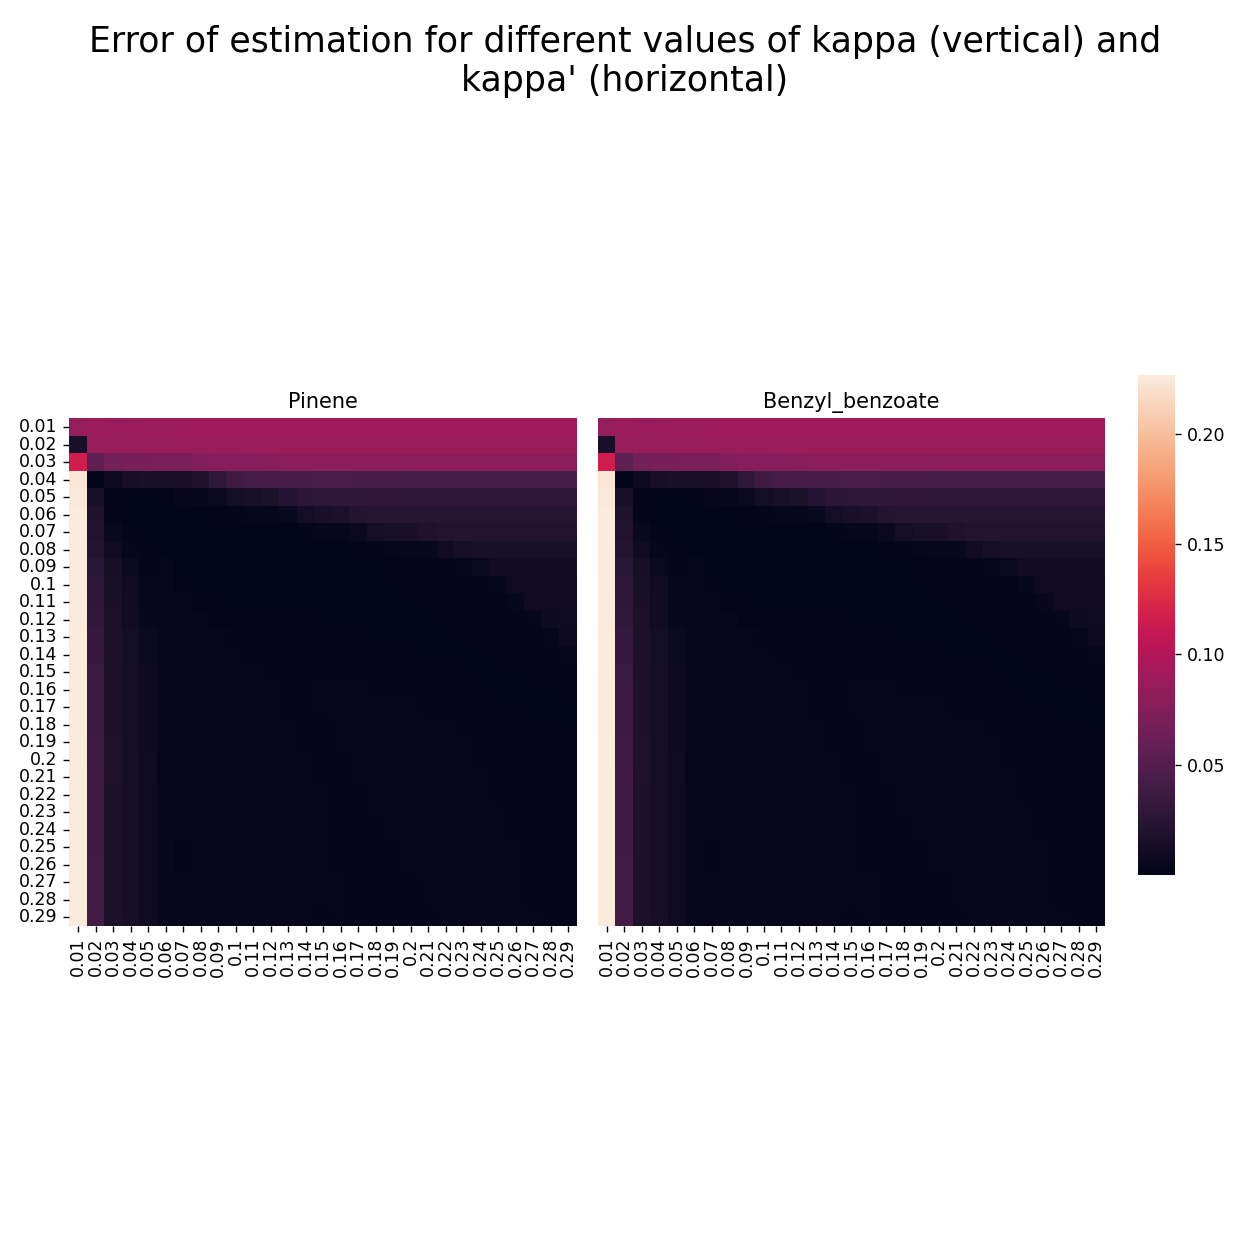

/tmp/ipykernel_286664/3364949664.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [36]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = official_names

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10), gridspec_kw=dict(width_ratios=2*[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')


for i, ax in enumerate(axs.ravel()):
    ax.set_title(names_for_plot[i])
    if i%2==0:
        ax.set_ylabel('kappa')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    if i%2==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True),
                )

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =20)


plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [37]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


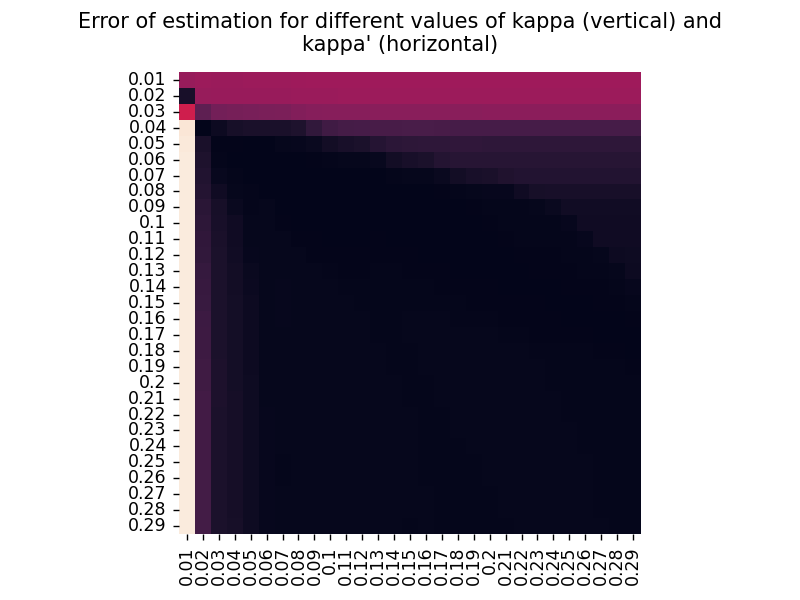

/tmp/ipykernel_286664/1306800419.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [38]:
vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()

sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [39]:
all_components_results_molar.min().min()

8.567098005674012e-06

In [40]:
all_components_results_molar[0.18000000000000002][0.09999999999999999]

8.567098005674012e-06

#### Visible proportions

In [41]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [42]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [43]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


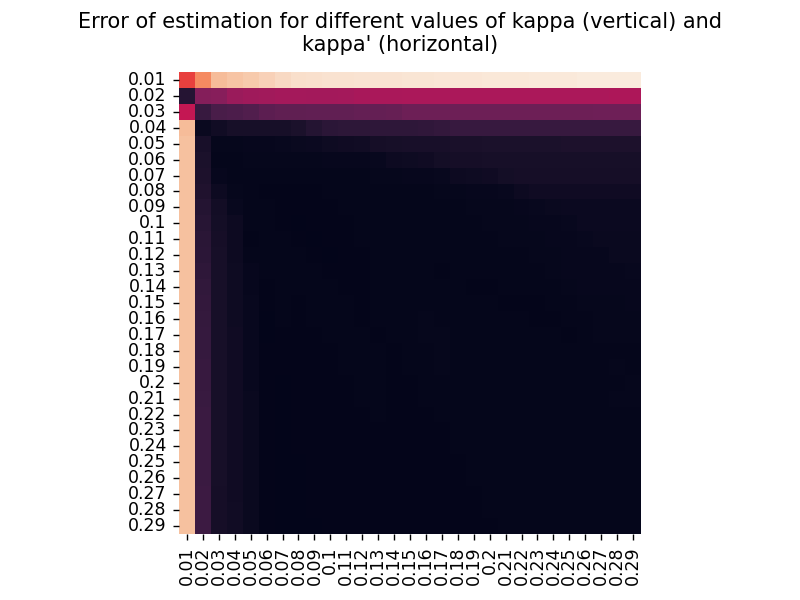

/tmp/ipykernel_286664/3671319860.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [44]:
vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()

sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [45]:
all_components_results_vis = all_components_results_vis.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [46]:
all_components_results_vis.min().min()

0.008183964100177216

In [47]:
all_components_results_vis[0.06999999999999999][0.29000000000000004]

0.008183964100177216

#### Both

In [48]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [49]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [50]:
all_components_results_both.min().min()

0.011008543679603217

In [51]:
all_components_results_both[0.08][0.09]

0.011008543679603217

### Estimation

In [52]:
estimation = estimate_proportions(mix, [comp0, comp1],
                                   MTD=0.09, MTD_th=0.08, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 62.62it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.0009999999999998899, 15.94445, 0), (0.0009999999999998899, 15.94445, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-0.0890000000000001, 16.03445)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3425632.71it/s]


Ion currents in chunks: [1.0000000000000056]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 524287 rows, 131075 columns and 1273086 nonzeros
Model fingerprint: 0x7a421666
Coefficient statistics:
  Matrix range     [7e-12, 1e+00]
  Objective range  [1e-11, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 9e-02]
Presolve removed 7605 rows and 0 columns (presolve time = 5s) ...
Presolve removed 14003 rows and 0 columns (presolve time = 10s) ...
Presolve removed 20193 rows and 0 columns (presolve time = 15s) ...
Presolve removed 22948 rows and 0 columns (presolve time = 20s) ...
Presolve removed 27009 rows and 0 columns (presolve time = 25s) ...
Presolve removed 29666 rows and 0 columns (presolve time = 30s) ...
Preso

Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.50s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9891180058439999
Noise proportion in experimental spectrum: 0.010881994154000017
Total explanation: 0.9999999999979999
Noise proportion in combination of theoretical spectra: 0.021767335575


In [53]:
estimation['proportion_of_noise_in_theoretical']

0.021767335575000123

In [54]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.11641497594500065, 0.8727030298990048]

In [55]:
real_visible_proportions

[0.11761626406540927, 0.8823837359345907]

In [56]:
estimated_molar_proportions = [estimated_visible_proportions[0]/16, estimated_visible_proportions[1]/12]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.09094784882652851, 0.9090521511734715]

In [57]:
molar_proportions

[0.09088457406472417, 0.9091154259352758]

### Visualisation of our estimation

In [58]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [59]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [60]:
p = estimated_visible_proportions

In [61]:
p = np.array(p).reshape(len(p),1)

In [62]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [63]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [64]:
X = np.concatenate(components_ints, axis=1)

In [65]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


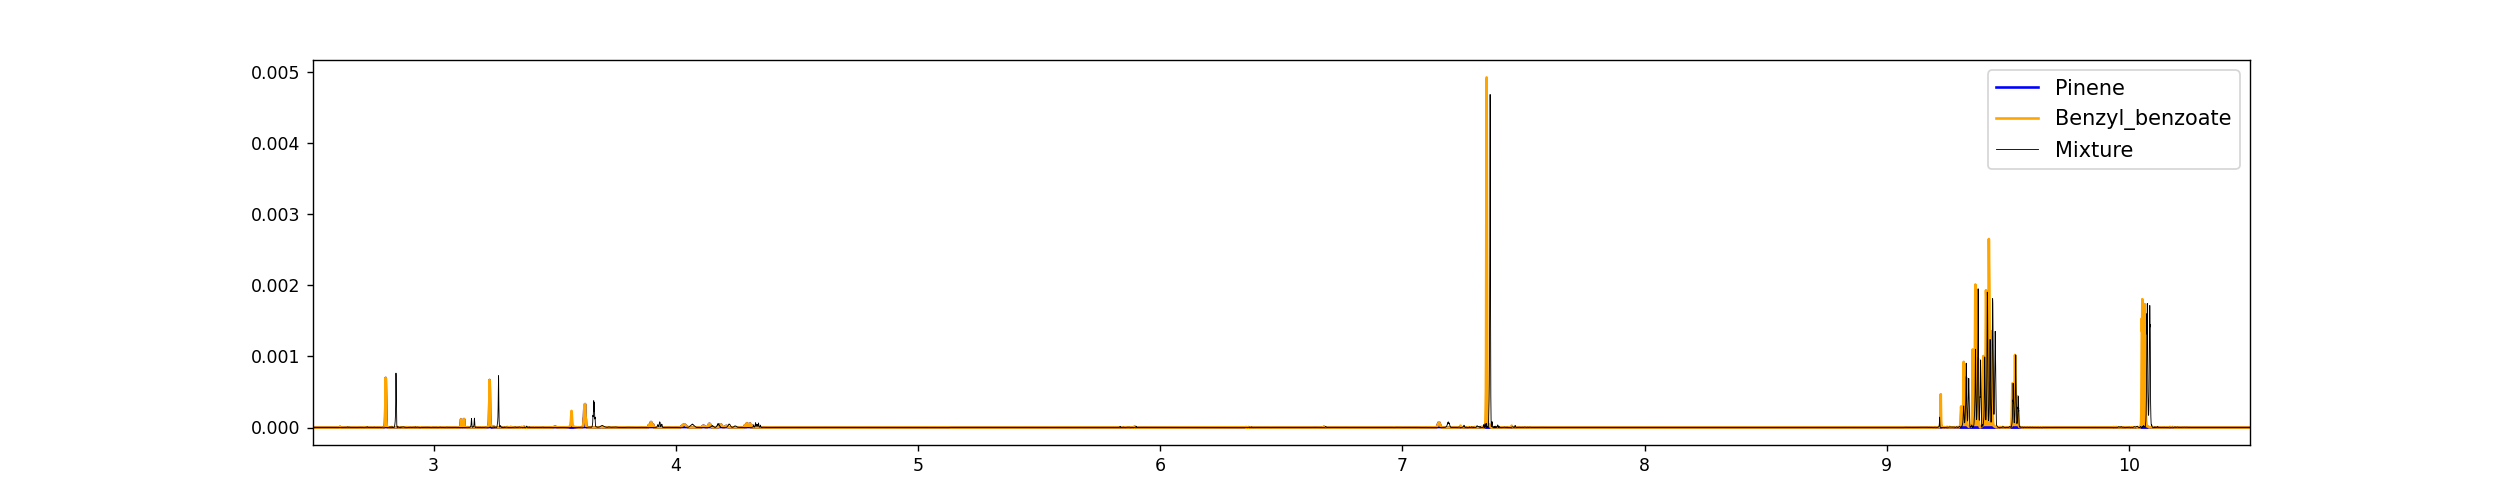

In [66]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(20, 4, forward=True)
ax.set_xlim(2.5,10.5)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})